# Multi-Model Training with GPU Acceleration
## Otto Product Classification Dataset

This notebook trains multiple machine learning models on the Otto dataset with GPU acceleration where available. We compare Random Forest, Decision Tree, XGBoost, LightGBM, and CatBoost.

## Step 1: Install Required Packages and GPU Detection

In [1]:
# Install required packages
import subprocess
import sys

packages = ['xgboost', 'lightgbm', 'catboost', 'cuml', 'torch']

print("Installing required packages...")
for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        print(f"✓ {package} installed successfully")

Installing required packages...
✓ xgboost already installed
✓ lightgbm already installed
Installing catboost...
✓ catboost installed successfully
✓ cuml already installed
✓ torch already installed


In [9]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import time
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("IMPORTING LIBRARIES")
print("=" * 80)
print("✓ All libraries imported successfully")

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

IMPORTING LIBRARIES
✓ All libraries imported successfully


In [3]:
# GPU Detection and Configuration
print("\n" + "=" * 80)
print("GPU DETECTION AND SETUP")
print("=" * 80)

gpu_available = False
gpu_info = "None"

# Check for CUDA availability
try:
    import torch
    if torch.cuda.is_available():
        gpu_available = True
        gpu_info = f"{torch.cuda.get_device_name(0)} (CUDA {torch.version.cuda})"
        print(f"✓ GPU Available: {gpu_info}")
    else:
        print("✗ GPU Not Available - CPU will be used")
except:
    print("✗ PyTorch not available - GPU detection skipped")

# Alternative: Check with CUDA toolkit
try:
    import subprocess
    result = subprocess.run(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'],
                          capture_output=True, text=True, timeout=5)
    if result.returncode == 0:
        gpu_info = result.stdout.strip().split('\n')[0]
        print(f"✓ NVIDIA GPU Detected: {gpu_info}")
except:
    pass

print(f"\nGPU Mode: {'ENABLED' if gpu_available else 'DISABLED'}")


GPU DETECTION AND SETUP
✗ PyTorch not available - GPU detection skipped
✗ PyTorch not available - GPU detection skipped
✓ NVIDIA GPU Detected: NVIDIA GeForce 840M

GPU Mode: DISABLED
✓ NVIDIA GPU Detected: NVIDIA GeForce 840M

GPU Mode: DISABLED


## Step 2: Load and Preprocess Data

In [10]:
print("\n" + "=" * 80)
print("LOADING AND PREPROCESSING DATA")
print("=" * 80)

# Load data
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')

print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")

# Prepare training features and target
X_train = train_data.drop(['id', 'target'], axis=1)
y_train = train_data['target']

# Prepare test features
X_test = test_data.drop(['id'], axis=1)

# Encode target labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)

print(f"\nNumber of classes: {len(le.classes_)}")
print(f"Classes: {le.classes_}")

# Note: Actual test labels are not available in test.csv
# Use a validation split from training data for monitoring during training
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"\nTraining set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set (unlabeled): {X_test.shape}")
print("✓ Data preprocessing completed")


LOADING AND PREPROCESSING DATA
Training set shape: (61878, 95)
Test set shape: (144368, 94)

Number of classes: 9
Classes: ['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']
Training set shape: (61878, 95)
Test set shape: (144368, 94)

Number of classes: 9
Classes: ['Class_1' 'Class_2' 'Class_3' 'Class_4' 'Class_5' 'Class_6' 'Class_7'
 'Class_8' 'Class_9']

Training set: (49502, 93)
Validation set: (12376, 93)
Test set (unlabeled): (144368, 93)
✓ Data preprocessing completed

Training set: (49502, 93)
Validation set: (12376, 93)
Test set (unlabeled): (144368, 93)
✓ Data preprocessing completed


## Step 3: Model Training with GPU Support

### Model 1: Random Forest Classifier

In [11]:
results = {}

print("\n" + "=" * 80)
print("MODEL 1: RANDOM FOREST CLASSIFIER")
print("=" * 80)

start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=30,
    max_features=15,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)
rf_model.fit(X_train_split, y_train_split)
rf_train_time = time.time() - start_time

# Predictions on validation set
y_pred_rf = rf_model.predict(X_val)
y_pred_proba_rf = rf_model.predict_proba(X_val)

# Evaluate
rf_accuracy = accuracy_score(y_val, y_pred_rf)
rf_logloss = log_loss(y_val, y_pred_proba_rf)

# Classification metrics for Random Forest
rf_precision_weighted = precision_score(y_val, y_pred_rf, average='weighted', zero_division=0)
rf_recall_weighted = recall_score(y_val, y_pred_rf, average='weighted', zero_division=0)
rf_f1_weighted = f1_score(y_val, y_pred_rf, average='weighted', zero_division=0)
rf_precision_macro = precision_score(y_val, y_pred_rf, average='macro', zero_division=0)
rf_recall_macro = recall_score(y_val, y_pred_rf, average='macro', zero_division=0)
rf_f1_macro = f1_score(y_val, y_pred_rf, average='macro', zero_division=0)

print(f"Training time: {rf_train_time:.2f} seconds")
print(f"\nPerformance Metrics:")
print(f"  • Accuracy:              {rf_accuracy:.4f}")
print(f"  • Log Loss:              {rf_logloss:.4f}")
print(f"  • Weighted F1-Score:     {rf_f1_weighted:.4f}")
print(f"  • Macro F1-Score:        {rf_f1_macro:.4f}")
print(f"  • Weighted Precision:    {rf_precision_weighted:.4f}")
print(f"  • Weighted Recall:       {rf_recall_weighted:.4f}")

results['Random Forest'] = {
    'model': rf_model,
    'accuracy': rf_accuracy,
    'logloss': rf_logloss,
    'train_time': rf_train_time,
    'y_pred': y_pred_rf,
    'y_pred_proba': y_pred_proba_rf,
    'f1_weighted': rf_f1_weighted,
    'precision_weighted': rf_precision_weighted,
    'recall_weighted': rf_recall_weighted,
    'f1_macro': rf_f1_macro,
    'precision_macro': rf_precision_macro,
    'recall_macro': rf_recall_macro
}


MODEL 1: RANDOM FOREST CLASSIFIER
Training time: 28.16 seconds

Performance Metrics:
  • Accuracy:              0.8062
  • Log Loss:              0.5623
  • Weighted F1-Score:     0.7963
  • Macro F1-Score:        0.7535
  • Weighted Precision:    0.8068
  • Weighted Recall:       0.8062
Training time: 28.16 seconds

Performance Metrics:
  • Accuracy:              0.8062
  • Log Loss:              0.5623
  • Weighted F1-Score:     0.7963
  • Macro F1-Score:        0.7535
  • Weighted Precision:    0.8068
  • Weighted Recall:       0.8062


### Model 2: Decision Tree Classifier

In [12]:
print("\n" + "=" * 80)
print("MODEL 2: DECISION TREE CLASSIFIER")
print("=" * 80)

start_time = time.time()
dt_model = DecisionTreeClassifier(
    max_depth=30,
    min_samples_leaf=1,
    random_state=42
)
dt_model.fit(X_train_split, y_train_split)
dt_train_time = time.time() - start_time

# Predictions on validation set
y_pred_dt = dt_model.predict(X_val)
y_pred_proba_dt = dt_model.predict_proba(X_val)

# Evaluate
dt_accuracy = accuracy_score(y_val, y_pred_dt)
dt_logloss = log_loss(y_val, y_pred_proba_dt)

# Classification metrics for Decision Tree
dt_precision_weighted = precision_score(y_val, y_pred_dt, average='weighted', zero_division=0)
dt_recall_weighted = recall_score(y_val, y_pred_dt, average='weighted', zero_division=0)
dt_f1_weighted = f1_score(y_val, y_pred_dt, average='weighted', zero_division=0)
dt_precision_macro = precision_score(y_val, y_pred_dt, average='macro', zero_division=0)
dt_recall_macro = recall_score(y_val, y_pred_dt, average='macro', zero_division=0)
dt_f1_macro = f1_score(y_val, y_pred_dt, average='macro', zero_division=0)

print(f"Training time: {dt_train_time:.2f} seconds")
print(f"\nPerformance Metrics:")
print(f"  • Accuracy:              {dt_accuracy:.4f}")
print(f"  • Log Loss:              {dt_logloss:.4f}")
print(f"  • Weighted F1-Score:     {dt_f1_weighted:.4f}")
print(f"  • Macro F1-Score:        {dt_f1_macro:.4f}")
print(f"  • Weighted Precision:    {dt_precision_weighted:.4f}")
print(f"  • Weighted Recall:       {dt_recall_weighted:.4f}")

results['Decision Tree'] = {
    'model': dt_model,
    'accuracy': dt_accuracy,
    'logloss': dt_logloss,
    'train_time': dt_train_time,
    'y_pred': y_pred_dt,
    'y_pred_proba': y_pred_proba_dt,
    'f1_weighted': dt_f1_weighted,
    'precision_weighted': dt_precision_weighted,
    'recall_weighted': dt_recall_weighted,
    'f1_macro': dt_f1_macro,
    'precision_macro': dt_precision_macro,
    'recall_macro': dt_recall_macro
}


MODEL 2: DECISION TREE CLASSIFIER
Training time: 3.32 seconds

Performance Metrics:
  • Accuracy:              0.7287
  • Log Loss:              7.0678
  • Weighted F1-Score:     0.7268
  • Macro F1-Score:        0.6628
  • Weighted Precision:    0.7260
  • Weighted Recall:       0.7287
Training time: 3.32 seconds

Performance Metrics:
  • Accuracy:              0.7287
  • Log Loss:              7.0678
  • Weighted F1-Score:     0.7268
  • Macro F1-Score:        0.6628
  • Weighted Precision:    0.7260
  • Weighted Recall:       0.7287


### Model 4: XGBoost with GPU Support

In [13]:
print("\n" + "=" * 80)
print("MODEL 4: XGBOOST WITH GPU SUPPORT")
print("=" * 80)


xgb_device = 'cuda' if gpu_available else 'cpu'
print(f"Device: {xgb_device}")

start_time = time.time()
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(le.classes_),
    tree_method='hist', # Use 'hist' or 'auto' with the 'device' parameter
    device=xgb_device,
    random_state=42,
    eval_metric='mlogloss',
    verbosity=0
)
xgb_model.fit(X_train_split, y_train_split)
xgb_train_time = time.time() - start_time

# Predictions on validation set
y_pred_xgb = xgb_model.predict(X_val)
y_pred_proba_xgb = xgb_model.predict_proba(X_val)

# Evaluate
xgb_accuracy = accuracy_score(y_val, y_pred_xgb)
xgb_logloss = log_loss(y_val, y_pred_proba_xgb)

# Classification metrics for XGBoost
xgb_precision_weighted = precision_score(y_val, y_pred_xgb, average='weighted', zero_division=0)
xgb_recall_weighted = recall_score(y_val, y_pred_xgb, average='weighted', zero_division=0)
xgb_f1_weighted = f1_score(y_val, y_pred_xgb, average='weighted', zero_division=0)
xgb_precision_macro = precision_score(y_val, y_pred_xgb, average='macro', zero_division=0)
xgb_recall_macro = recall_score(y_val, y_pred_xgb, average='macro', zero_division=0)
xgb_f1_macro = f1_score(y_val, y_pred_xgb, average='macro', zero_division=0)

print(f"Training time: {xgb_train_time:.2f} seconds")
print(f"\nPerformance Metrics:")
print(f"  • Accuracy:              {xgb_accuracy:.4f}")
print(f"  • Log Loss:              {xgb_logloss:.4f}")
print(f"  • Weighted F1-Score:     {xgb_f1_weighted:.4f}")
print(f"  • Macro F1-Score:        {xgb_f1_macro:.4f}")
print(f"  • Weighted Precision:    {xgb_precision_weighted:.4f}")
print(f"  • Weighted Recall:       {xgb_recall_weighted:.4f}")

results['XGBoost'] = {
    'model': xgb_model,
    'accuracy': xgb_accuracy,
    'logloss': xgb_logloss,
    'train_time': xgb_train_time,
    'y_pred': y_pred_xgb,
    'y_pred_proba': y_pred_proba_xgb,
    'f1_weighted': xgb_f1_weighted,
    'precision_weighted': xgb_precision_weighted,
    'recall_weighted': xgb_recall_weighted,
    'f1_macro': xgb_f1_macro,
    'precision_macro': xgb_precision_macro,
    'recall_macro': xgb_recall_macro
}


MODEL 4: XGBOOST WITH GPU SUPPORT
Device: cpu
Training time: 59.54 seconds

Performance Metrics:
  • Accuracy:              0.8295
  • Log Loss:              0.4510
  • Weighted F1-Score:     0.8257
  • Macro F1-Score:        0.7940
  • Weighted Precision:    0.8280
  • Weighted Recall:       0.8295
Training time: 59.54 seconds

Performance Metrics:
  • Accuracy:              0.8295
  • Log Loss:              0.4510
  • Weighted F1-Score:     0.8257
  • Macro F1-Score:        0.7940
  • Weighted Precision:    0.8280
  • Weighted Recall:       0.8295


### Model 5: LightGBM with GPU Support

In [14]:
print("\n" + "=" * 80)
print("MODEL 5: LIGHTGBM WITH GPU SUPPORT")
print("=" * 80)

# Use GPU if available
lgb_device = 'gpu' if gpu_available else 'cpu'
print(f"Device: {lgb_device}")

start_time = time.time()
lgb_model = lgb.LGBMClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    device=lgb_device,
    n_jobs=-1,
    random_state=42,
    verbosity=-1
)
lgb_model.fit(X_train_split, y_train_split)
lgb_train_time = time.time() - start_time

# Predictions on validation set
y_pred_lgb = lgb_model.predict(X_val)
y_pred_proba_lgb = lgb_model.predict_proba(X_val)

# Evaluate
lgb_accuracy = accuracy_score(y_val, y_pred_lgb)
lgb_logloss = log_loss(y_val, y_pred_proba_lgb)

# Classification metrics for LightGBM
lgb_precision_weighted = precision_score(y_val, y_pred_lgb, average='weighted', zero_division=0)
lgb_recall_weighted = recall_score(y_val, y_pred_lgb, average='weighted', zero_division=0)
lgb_f1_weighted = f1_score(y_val, y_pred_lgb, average='weighted', zero_division=0)
lgb_precision_macro = precision_score(y_val, y_pred_lgb, average='macro', zero_division=0)
lgb_recall_macro = recall_score(y_val, y_pred_lgb, average='macro', zero_division=0)
lgb_f1_macro = f1_score(y_val, y_pred_lgb, average='macro', zero_division=0)

print(f"Training time: {lgb_train_time:.2f} seconds")
print(f"\nPerformance Metrics:")
print(f"  • Accuracy:              {lgb_accuracy:.4f}")
print(f"  • Log Loss:              {lgb_logloss:.4f}")
print(f"  • Weighted F1-Score:     {lgb_f1_weighted:.4f}")
print(f"  • Macro F1-Score:        {lgb_f1_macro:.4f}")
print(f"  • Weighted Precision:    {lgb_precision_weighted:.4f}")
print(f"  • Weighted Recall:       {lgb_recall_weighted:.4f}")

results['LightGBM'] = {
    'model': lgb_model,
    'accuracy': lgb_accuracy,
    'logloss': lgb_logloss,
    'train_time': lgb_train_time,
    'y_pred': y_pred_lgb,
    'y_pred_proba': y_pred_proba_lgb,
    'f1_weighted': lgb_f1_weighted,
    'precision_weighted': lgb_precision_weighted,
    'recall_weighted': lgb_recall_weighted,
    'f1_macro': lgb_f1_macro,
    'precision_macro': lgb_precision_macro,
    'recall_macro': lgb_recall_macro
}


MODEL 5: LIGHTGBM WITH GPU SUPPORT
Device: cpu
Training time: 21.58 seconds

Performance Metrics:
  • Accuracy:              0.8239
  • Log Loss:              0.4683
  • Weighted F1-Score:     0.8196
  • Macro F1-Score:        0.7877
  • Weighted Precision:    0.8217
  • Weighted Recall:       0.8239
Training time: 21.58 seconds

Performance Metrics:
  • Accuracy:              0.8239
  • Log Loss:              0.4683
  • Weighted F1-Score:     0.8196
  • Macro F1-Score:        0.7877
  • Weighted Precision:    0.8217
  • Weighted Recall:       0.8239


### Model 6: CatBoost with GPU Support

In [15]:
print("\n" + "=" * 80)
print("MODEL 6: CATBOOST WITH GPU SUPPORT")
print("=" * 80)

# Use GPU if available
catboost_processor = 'GPU' if gpu_available else 'CPU'
print(f"Processor: {catboost_processor}")

start_time = time.time()
catboost_model = CatBoostClassifier(
    iterations=300,
    depth=8,
    learning_rate=0.1,
    subsample=0.8,
    l2_leaf_reg=3,
    bootstrap_type='Bernoulli',            # Bernoulli bootstrap supports 'subsample'
    task_type=catboost_processor,
    devices='0' if gpu_available else None,
    random_state=42,
    verbose=False,
    loss_function='MultiClass'
)
catboost_model.fit(X_train_split, y_train_split, verbose=False)
catboost_train_time = time.time() - start_time

# Predictions on validation set
y_pred_catboost = catboost_model.predict(X_val)
y_pred_proba_catboost = catboost_model.predict_proba(X_val)

# Evaluate
catboost_accuracy = accuracy_score(y_val, y_pred_catboost)
catboost_logloss = log_loss(y_val, y_pred_proba_catboost)

# Classification metrics for CatBoost
catboost_precision_weighted = precision_score(y_val, y_pred_catboost, average='weighted', zero_division=0)
catboost_recall_weighted = recall_score(y_val, y_pred_catboost, average='weighted', zero_division=0)
catboost_f1_weighted = f1_score(y_val, y_pred_catboost, average='weighted', zero_division=0)
catboost_precision_macro = precision_score(y_val, y_pred_catboost, average='macro', zero_division=0)
catboost_recall_macro = recall_score(y_val, y_pred_catboost, average='macro', zero_division=0)
catboost_f1_macro = f1_score(y_val, y_pred_catboost, average='macro', zero_division=0)

print(f"Training time: {catboost_train_time:.2f} seconds")
print(f"\nPerformance Metrics:")
print(f"  • Accuracy:              {catboost_accuracy:.4f}")
print(f"  • Log Loss:              {catboost_logloss:.4f}")
print(f"  • Weighted F1-Score:     {catboost_f1_weighted:.4f}")
print(f"  • Macro F1-Score:        {catboost_f1_macro:.4f}")
print(f"  • Weighted Precision:    {catboost_precision_weighted:.4f}")
print(f"  • Weighted Recall:       {catboost_recall_weighted:.4f}")

results['CatBoost'] = {
    'model': catboost_model,
    'accuracy': catboost_accuracy,
    'logloss': catboost_logloss,
    'train_time': catboost_train_time,
    'y_pred': y_pred_catboost,
    'y_pred_proba': y_pred_proba_catboost,
    'f1_weighted': catboost_f1_weighted,
    'precision_weighted': catboost_precision_weighted,
    'recall_weighted': catboost_recall_weighted,
    'f1_macro': catboost_f1_macro,
    'precision_macro': catboost_precision_macro,
    'recall_macro': catboost_recall_macro
}


MODEL 6: CATBOOST WITH GPU SUPPORT
Processor: CPU
Training time: 225.49 seconds

Performance Metrics:
  • Accuracy:              0.8066
  • Log Loss:              0.5211
  • Weighted F1-Score:     0.7987
  • Macro F1-Score:        0.7602
  • Weighted Precision:    0.8043
  • Weighted Recall:       0.8066
Training time: 225.49 seconds

Performance Metrics:
  • Accuracy:              0.8066
  • Log Loss:              0.5211
  • Weighted F1-Score:     0.7987
  • Macro F1-Score:        0.7602
  • Weighted Precision:    0.8043
  • Weighted Recall:       0.8066


## Step 4: Model Comparison and Results

In [16]:
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

# Create comparison dataframe with comprehensive metrics
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Log Loss': [results[m]['logloss'] for m in results.keys()],
    'F1-Score (Weighted)': [results[m]['f1_weighted'] for m in results.keys()],
    'F1-Score (Macro)': [results[m]['f1_macro'] for m in results.keys()],
    'Precision (W)': [results[m]['precision_weighted'] for m in results.keys()],
    'Recall (W)': [results[m]['recall_weighted'] for m in results.keys()],
    'Training Time (s)': [results[m]['train_time'] for m in results.keys()]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print("\nDetailed Performance Metrics:")
print(comparison_df.to_string(index=False))

# Find best models
best_accuracy_model = comparison_df.iloc[0]['Model']
best_logloss_model = comparison_df.loc[comparison_df['Log Loss'].idxmin(), 'Model']
best_f1_model = comparison_df.loc[comparison_df['F1-Score (Weighted)'].idxmin(), 'Model']
fastest_model = comparison_df.loc[comparison_df['Training Time (s)'].idxmin(), 'Model']

print(f"\n{'='*70}")
print("BEST MODELS SUMMARY:")
print(f"{'='*70}")
print(f"✓ Best Accuracy:       {best_accuracy_model} ({comparison_df.iloc[0]['Accuracy']:.4f})")
print(f"✓ Best Log Loss:       {best_logloss_model} ({comparison_df['Log Loss'].min():.4f})")
print(f"✓ Best F1-Score:       {best_f1_model} ({comparison_df['F1-Score (Weighted)'].max():.4f})")
print(f"✓ Fastest Training:    {fastest_model} ({comparison_df['Training Time (s)'].min():.2f}s)")
print(f"{'='*70}")


MODEL COMPARISON SUMMARY

Detailed Performance Metrics:
        Model  Accuracy  Log Loss  F1-Score (Weighted)  F1-Score (Macro)  Precision (W)  Recall (W)  Training Time (s)
      XGBoost  0.829509  0.450984             0.825666          0.794027       0.828020    0.829509          59.538290
     LightGBM  0.823853  0.468263             0.819584          0.787738       0.821712    0.823853          21.576203
     CatBoost  0.806561  0.521084             0.798717          0.760233       0.804309    0.806561         225.490458
Random Forest  0.806157  0.562302             0.796254          0.753460       0.806757    0.806157          28.159027
Decision Tree  0.728749  7.067791             0.726777          0.662807       0.726037    0.728749           3.321157

BEST MODELS SUMMARY:
✓ Best Accuracy:       XGBoost (0.8295)
✓ Best Log Loss:       XGBoost (0.4510)
✓ Best F1-Score:       Decision Tree (0.8257)
✓ Fastest Training:    Decision Tree (3.32s)


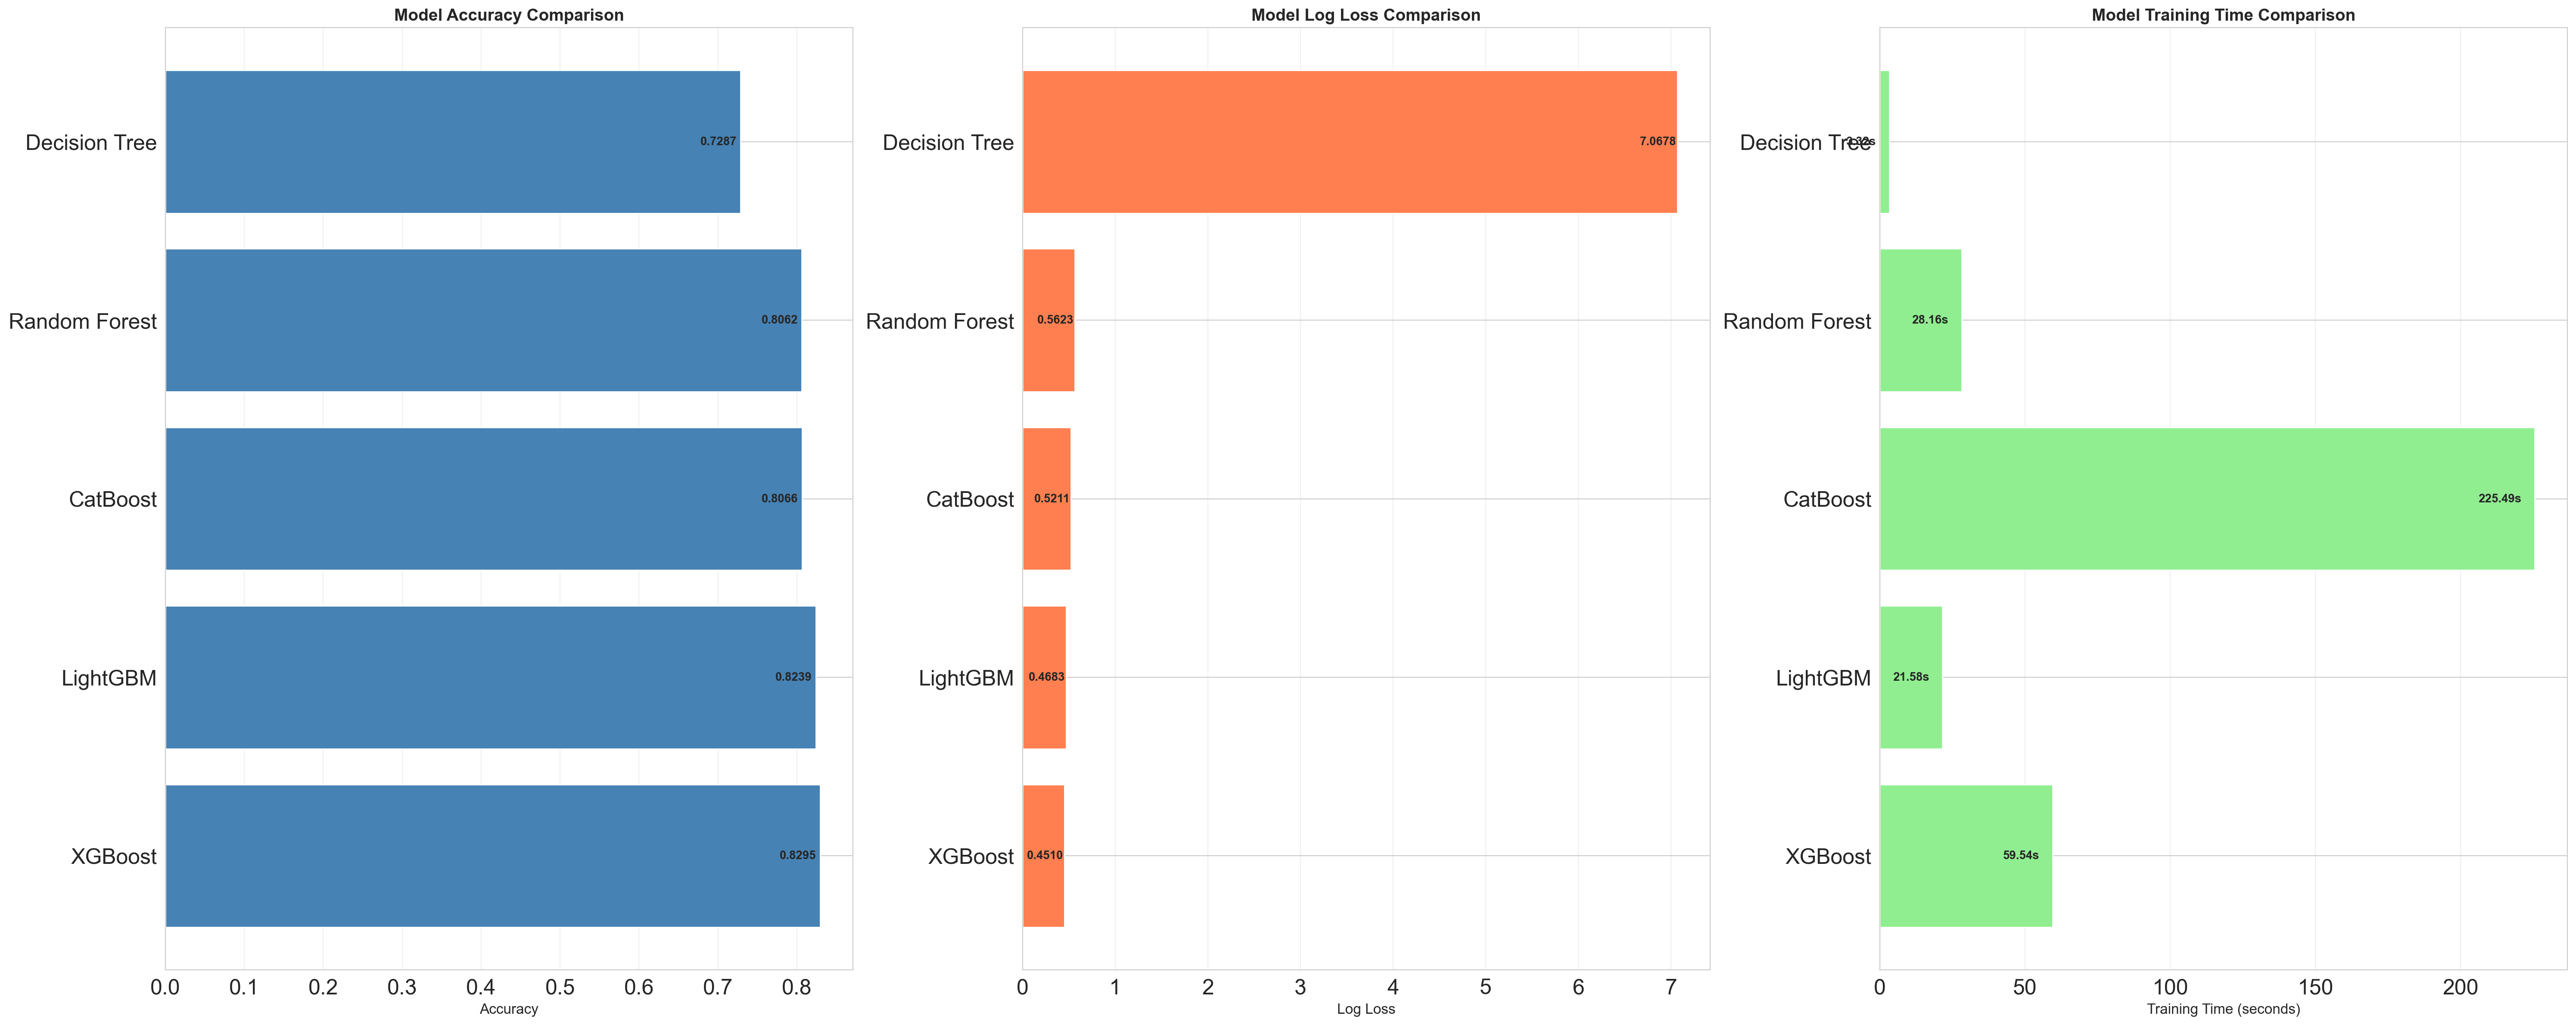

In [17]:
# Visualize model comparison (larger and high-DPI)
fig, axes = plt.subplots(1, 3, figsize=(30, 12), dpi=200)

# Accuracy comparison
axes[0].barh(comparison_df['Model'], comparison_df['Accuracy'], color='steelblue')
axes[0].set_xlabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontweight='bold', fontsize=14)
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['Accuracy']):
    axes[0].text(v - 0.005, i, f'{v:.4f}', va='center', ha='right', fontweight='bold', fontsize=10)

# Log Loss comparison
axes[1].barh(comparison_df['Model'], comparison_df['Log Loss'], color='coral')
axes[1].set_xlabel('Log Loss', fontsize=12)
axes[1].set_title('Model Log Loss Comparison', fontweight='bold', fontsize=14)
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(comparison_df['Log Loss']):
    axes[1].text(v - 0.01, i, f'{v:.4f}', va='center', ha='right', fontweight='bold', fontsize=10)

# Training time comparison
axes[2].barh(comparison_df['Model'], comparison_df['Training Time (s)'], color='lightgreen')
axes[2].set_xlabel('Training Time (seconds)', fontsize=12)
axes[2].set_title('Model Training Time Comparison', fontweight='bold', fontsize=14)
axes[2].grid(axis='x', alpha=0.3)
max_time = comparison_df['Training Time (s)'].max()
for i, v in enumerate(comparison_df['Training Time (s)']):
    axes[2].text(v - max_time*0.02, i, f'{v:.2f}s', va='center', ha='right', fontweight='bold', fontsize=10)

# Increase tick label sizes for readability
for ax in axes:
    ax.tick_params(axis='x', labelsize=18)
    ax.tick_params(axis='y', labelsize=18)

plt.tight_layout()
plt.show()

In [18]:
print("\n" + "=" * 80)
print("DETAILED ACCURACY AND ERROR ANALYSIS")
print("=" * 80)

# Calculate training errors (using predictions on training set)
train_errors = {}
val_errors = {}
train_accuracies = {}

for model_name in results.keys():
    model = results[model_name]['model']

    # Training predictions and accuracy
    y_train_pred = model.predict(X_train_split)
    y_train_proba = model.predict_proba(X_train_split)

    train_acc = accuracy_score(y_train_split, y_train_pred)
    train_err = log_loss(y_train_split, y_train_proba)

    # Validation predictions and accuracy (already calculated)
    val_acc = results[model_name]['accuracy']
    val_err = results[model_name]['logloss']

    train_accuracies[model_name] = train_acc
    train_errors[model_name] = train_err
    val_errors[model_name] = val_err

    print(f"\n{model_name}:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Training Log Loss: {train_err:.4f}")
    print(f"  Validation Log Loss: {val_err:.4f}")
    print(f"  Overfitting Gap: {(train_acc - val_acc):.4f}")

# Create comparison dataframe with all metrics
detailed_comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Accuracy': [train_accuracies[m] for m in results.keys()],
    'Val Accuracy': [results[m]['accuracy'] for m in results.keys()],
    'Train Error': [train_errors[m] for m in results.keys()],
    'Val Error': [val_errors[m] for m in results.keys()],
})

print("\n" + "=" * 80)
print("DETAILED METRICS TABLE")
print("=" * 80)
print(detailed_comparison.to_string(index=False))


DETAILED ACCURACY AND ERROR ANALYSIS

Random Forest:
  Training Accuracy: 0.9751
  Validation Accuracy: 0.8062
  Training Log Loss: 0.2225
  Validation Log Loss: 0.5623
  Overfitting Gap: 0.1689

Decision Tree:
  Training Accuracy: 0.9367
  Validation Accuracy: 0.7287
  Training Log Loss: 0.1808
  Validation Log Loss: 7.0678
  Overfitting Gap: 0.2080

Random Forest:
  Training Accuracy: 0.9751
  Validation Accuracy: 0.8062
  Training Log Loss: 0.2225
  Validation Log Loss: 0.5623
  Overfitting Gap: 0.1689

Decision Tree:
  Training Accuracy: 0.9367
  Validation Accuracy: 0.7287
  Training Log Loss: 0.1808
  Validation Log Loss: 7.0678
  Overfitting Gap: 0.2080

XGBoost:
  Training Accuracy: 0.9581
  Validation Accuracy: 0.8295
  Training Log Loss: 0.1638
  Validation Log Loss: 0.4510
  Overfitting Gap: 0.1286

XGBoost:
  Training Accuracy: 0.9581
  Validation Accuracy: 0.8295
  Training Log Loss: 0.1638
  Validation Log Loss: 0.4510
  Overfitting Gap: 0.1286

LightGBM:
  Training Accu

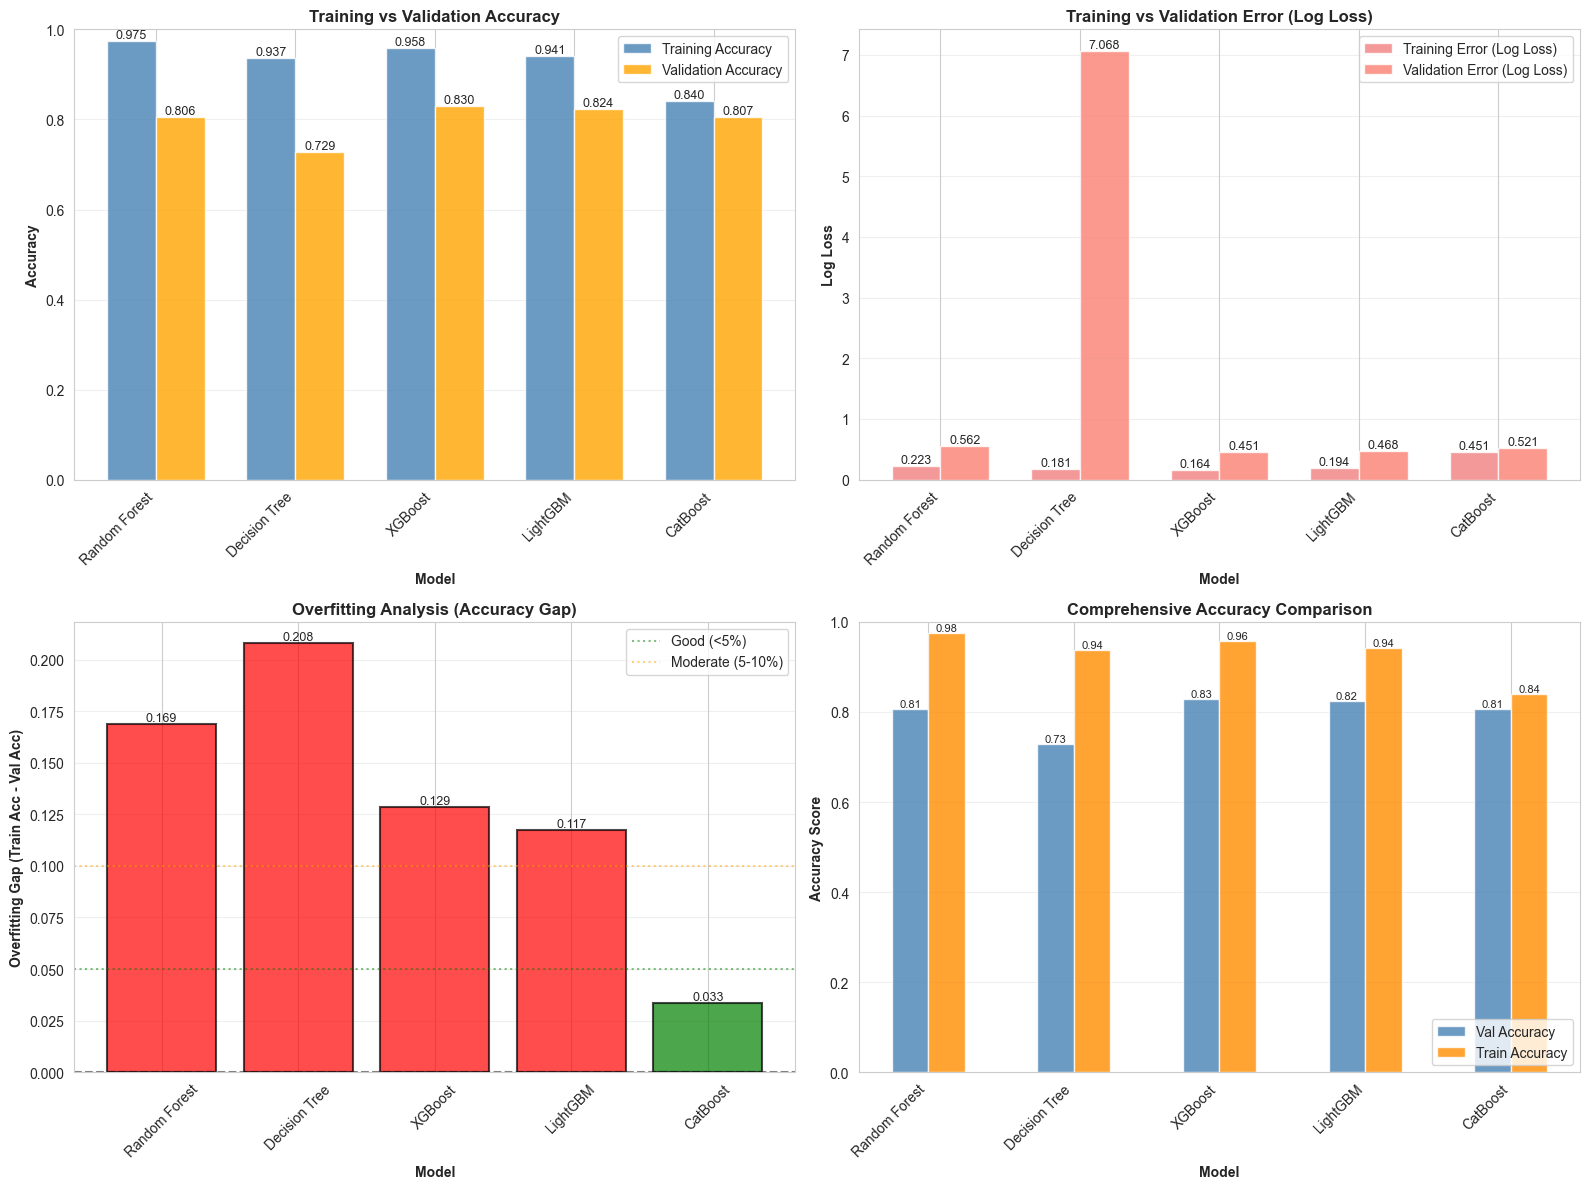


✓ Comprehensive accuracy and error plots generated!


In [19]:
# Plot 1: Training vs Validation Accuracy
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_list = list(results.keys())
x_pos = np.arange(len(models_list))
width = 0.35

# Subplot 1: Training vs Validation Accuracy
ax1 = axes[0, 0]
train_acc = [train_accuracies[m] for m in models_list]
val_acc = [results[m]['accuracy'] for m in models_list]

bars1 = ax1.bar(x_pos - width/2, train_acc, width, label='Training Accuracy', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x_pos + width/2, val_acc, width, label='Validation Accuracy', color='orange', alpha=0.8)

ax1.set_xlabel('Model', fontweight='bold')
ax1.set_ylabel('Accuracy', fontweight='bold')
ax1.set_title('Training vs Validation Accuracy', fontweight='bold', fontsize=12)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models_list, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Subplot 2: Training vs Validation Error (Log Loss)
ax2 = axes[0, 1]
train_err = [train_errors[m] for m in models_list]
val_err = [val_errors[m] for m in models_list]

bars3 = ax2.bar(x_pos - width/2, train_err, width, label='Training Error (Log Loss)', color='lightcoral', alpha=0.8)
bars4 = ax2.bar(x_pos + width/2, val_err, width, label='Validation Error (Log Loss)', color='salmon', alpha=0.8)

ax2.set_xlabel('Model', fontweight='bold')
ax2.set_ylabel('Log Loss', fontweight='bold')
ax2.set_title('Training vs Validation Error (Log Loss)', fontweight='bold', fontsize=12)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models_list, rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

# Subplot 3: Overfitting Analysis (Train - Val Accuracy)
ax3 = axes[1, 0]
overfitting_gap = [train_accuracies[m] - results[m]['accuracy'] for m in models_list]
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.1 else 'red' for gap in overfitting_gap]

bars5 = ax3.bar(models_list, overfitting_gap, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax3.set_xlabel('Model', fontweight='bold')
ax3.set_ylabel('Overfitting Gap (Train Acc - Val Acc)', fontweight='bold')
ax3.set_title('Overfitting Analysis (Accuracy Gap)', fontweight='bold', fontsize=12)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.axhline(y=0.05, color='green', linestyle=':', alpha=0.5, label='Good (<5%)')
ax3.axhline(y=0.1, color='orange', linestyle=':', alpha=0.5, label='Moderate (5-10%)')
ax3.tick_params(axis='x', rotation=45)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars5:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=9)

# Subplot 4: Overall Model Performance Comparison
ax4 = axes[1, 1]
metrics_data = {
    'Val Accuracy': val_acc,
    'Train Accuracy': train_acc,
}

x = np.arange(len(models_list))
width = 0.25
multiplier = 0

colors_list = ['steelblue', 'darkorange']
for idx, (attribute, measurement) in enumerate(metrics_data.items()):
    offset = width * multiplier
    bars = ax4.bar(x + offset, measurement, width, label=attribute, color=colors_list[idx], alpha=0.8)

    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

    multiplier += 1

ax4.set_xlabel('Model', fontweight='bold')
ax4.set_ylabel('Accuracy Score', fontweight='bold')
ax4.set_title('Comprehensive Accuracy Comparison', fontweight='bold', fontsize=12)
ax4.set_xticks(x + width / 2)
ax4.set_xticklabels(models_list, rotation=45, ha='right')
ax4.legend(loc='lower right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n✓ Comprehensive accuracy and error plots generated!")

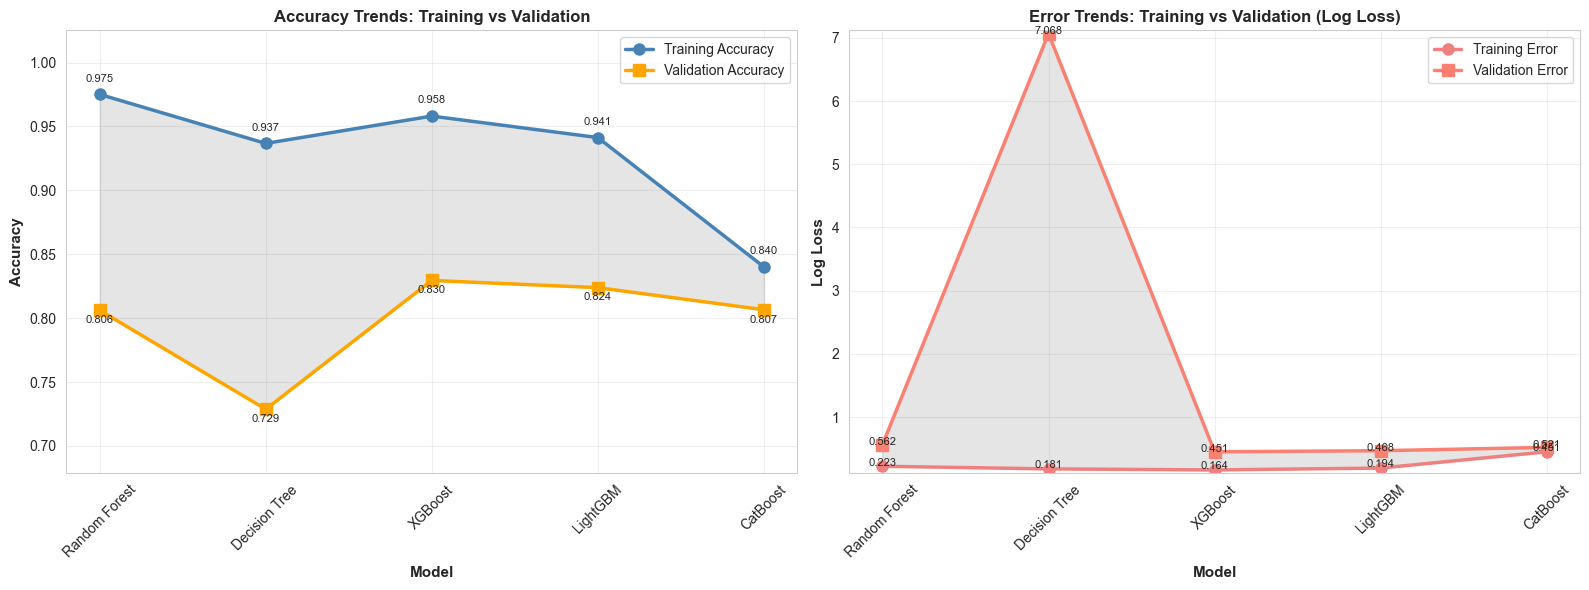

✓ Trend line plots generated!


In [20]:
# Plot 2: Line plots showing trends
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

models_list = list(results.keys())

# Subplot 1: Accuracy Trend Line Plot
ax1 = axes[0]
ax1.plot(models_list, train_acc, marker='o', linewidth=2.5, markersize=8, label='Training Accuracy', color='steelblue')
ax1.plot(models_list, val_acc, marker='s', linewidth=2.5, markersize=8, label='Validation Accuracy', color='orange')
ax1.fill_between(range(len(models_list)), train_acc, val_acc, alpha=0.2, color='gray')

ax1.set_xlabel('Model', fontweight='bold', fontsize=11)
ax1.set_ylabel('Accuracy', fontweight='bold', fontsize=11)
ax1.set_title('Accuracy Trends: Training vs Validation', fontweight='bold', fontsize=12)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([min(min(train_acc), min(val_acc)) - 0.05, max(max(train_acc), max(val_acc)) + 0.05])
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for i, (t, v) in enumerate(zip(train_acc, val_acc)):
    ax1.text(i, t + 0.01, f'{t:.3f}', ha='center', fontsize=8)
    ax1.text(i, v - 0.01, f'{v:.3f}', ha='center', fontsize=8)

# Subplot 2: Error (Log Loss) Trend Line Plot
ax2 = axes[1]
ax2.plot(models_list, train_err, marker='o', linewidth=2.5, markersize=8, label='Training Error', color='lightcoral')
ax2.plot(models_list, val_err, marker='s', linewidth=2.5, markersize=8, label='Validation Error', color='salmon')
ax2.fill_between(range(len(models_list)), train_err, val_err, alpha=0.2, color='gray')

ax2.set_xlabel('Model', fontweight='bold', fontsize=11)
ax2.set_ylabel('Log Loss', fontweight='bold', fontsize=11)
ax2.set_title('Error Trends: Training vs Validation (Log Loss)', fontweight='bold', fontsize=12)
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([min(min(train_err), min(val_err)) - 0.05, max(max(train_err), max(val_err)) + 0.05])
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for i, (t, v) in enumerate(zip(train_err, val_err)):
    ax2.text(i, t + 0.01, f'{t:.3f}', ha='center', fontsize=8)
    ax2.text(i, v - 0.01, f'{v:.3f}', ha='center', fontsize=8)

plt.tight_layout()
plt.show()

print("✓ Trend line plots generated!")

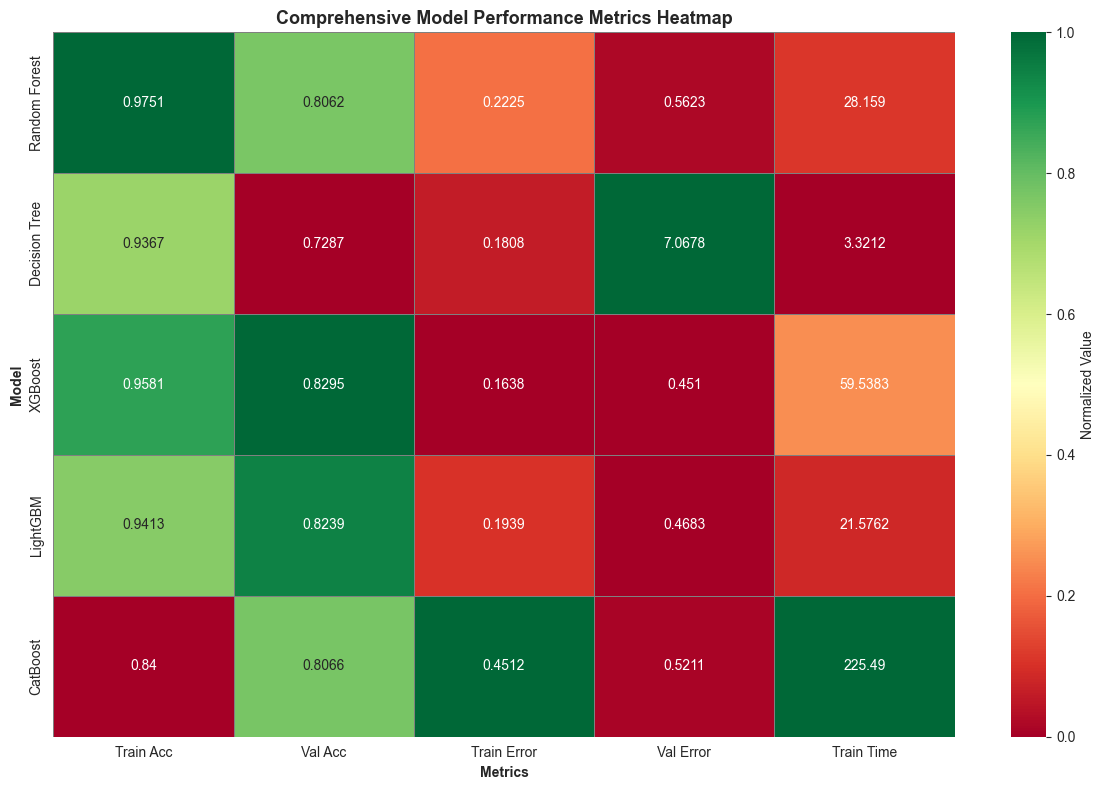

✓ Heatmap of all metrics generated!


In [21]:
# Plot 3: Heatmap of all metrics
fig, ax = plt.subplots(figsize=(12, 8))

# Prepare data for heatmap
heatmap_data = pd.DataFrame({
    'Train Acc': [train_accuracies[m] for m in models_list],
    'Val Acc': [results[m]['accuracy'] for m in models_list],
    'Train Error': [train_errors[m] for m in models_list],
    'Val Error': [val_errors[m] for m in models_list],
    'Train Time': [results[m]['train_time'] for m in models_list],
}, index=models_list)

# Normalize the data for better visualization (0-1 scale)
heatmap_normalized = heatmap_data.copy()
for col in heatmap_normalized.columns:
    min_val = heatmap_normalized[col].min()
    max_val = heatmap_normalized[col].max()
    if max_val > min_val:
        heatmap_normalized[col] = (heatmap_normalized[col] - min_val) / (max_val - min_val)
    else:
        heatmap_normalized[col] = 0.5

# Create heatmap
sns.heatmap(heatmap_normalized, annot=heatmap_data.round(4), fmt='g', cmap='RdYlGn',
            cbar_kws={'label': 'Normalized Value'}, ax=ax, linewidths=0.5, linecolor='gray')

ax.set_title('Comprehensive Model Performance Metrics Heatmap', fontweight='bold', fontsize=13)
ax.set_ylabel('Model', fontweight='bold')
ax.set_xlabel('Metrics', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Heatmap of all metrics generated!")

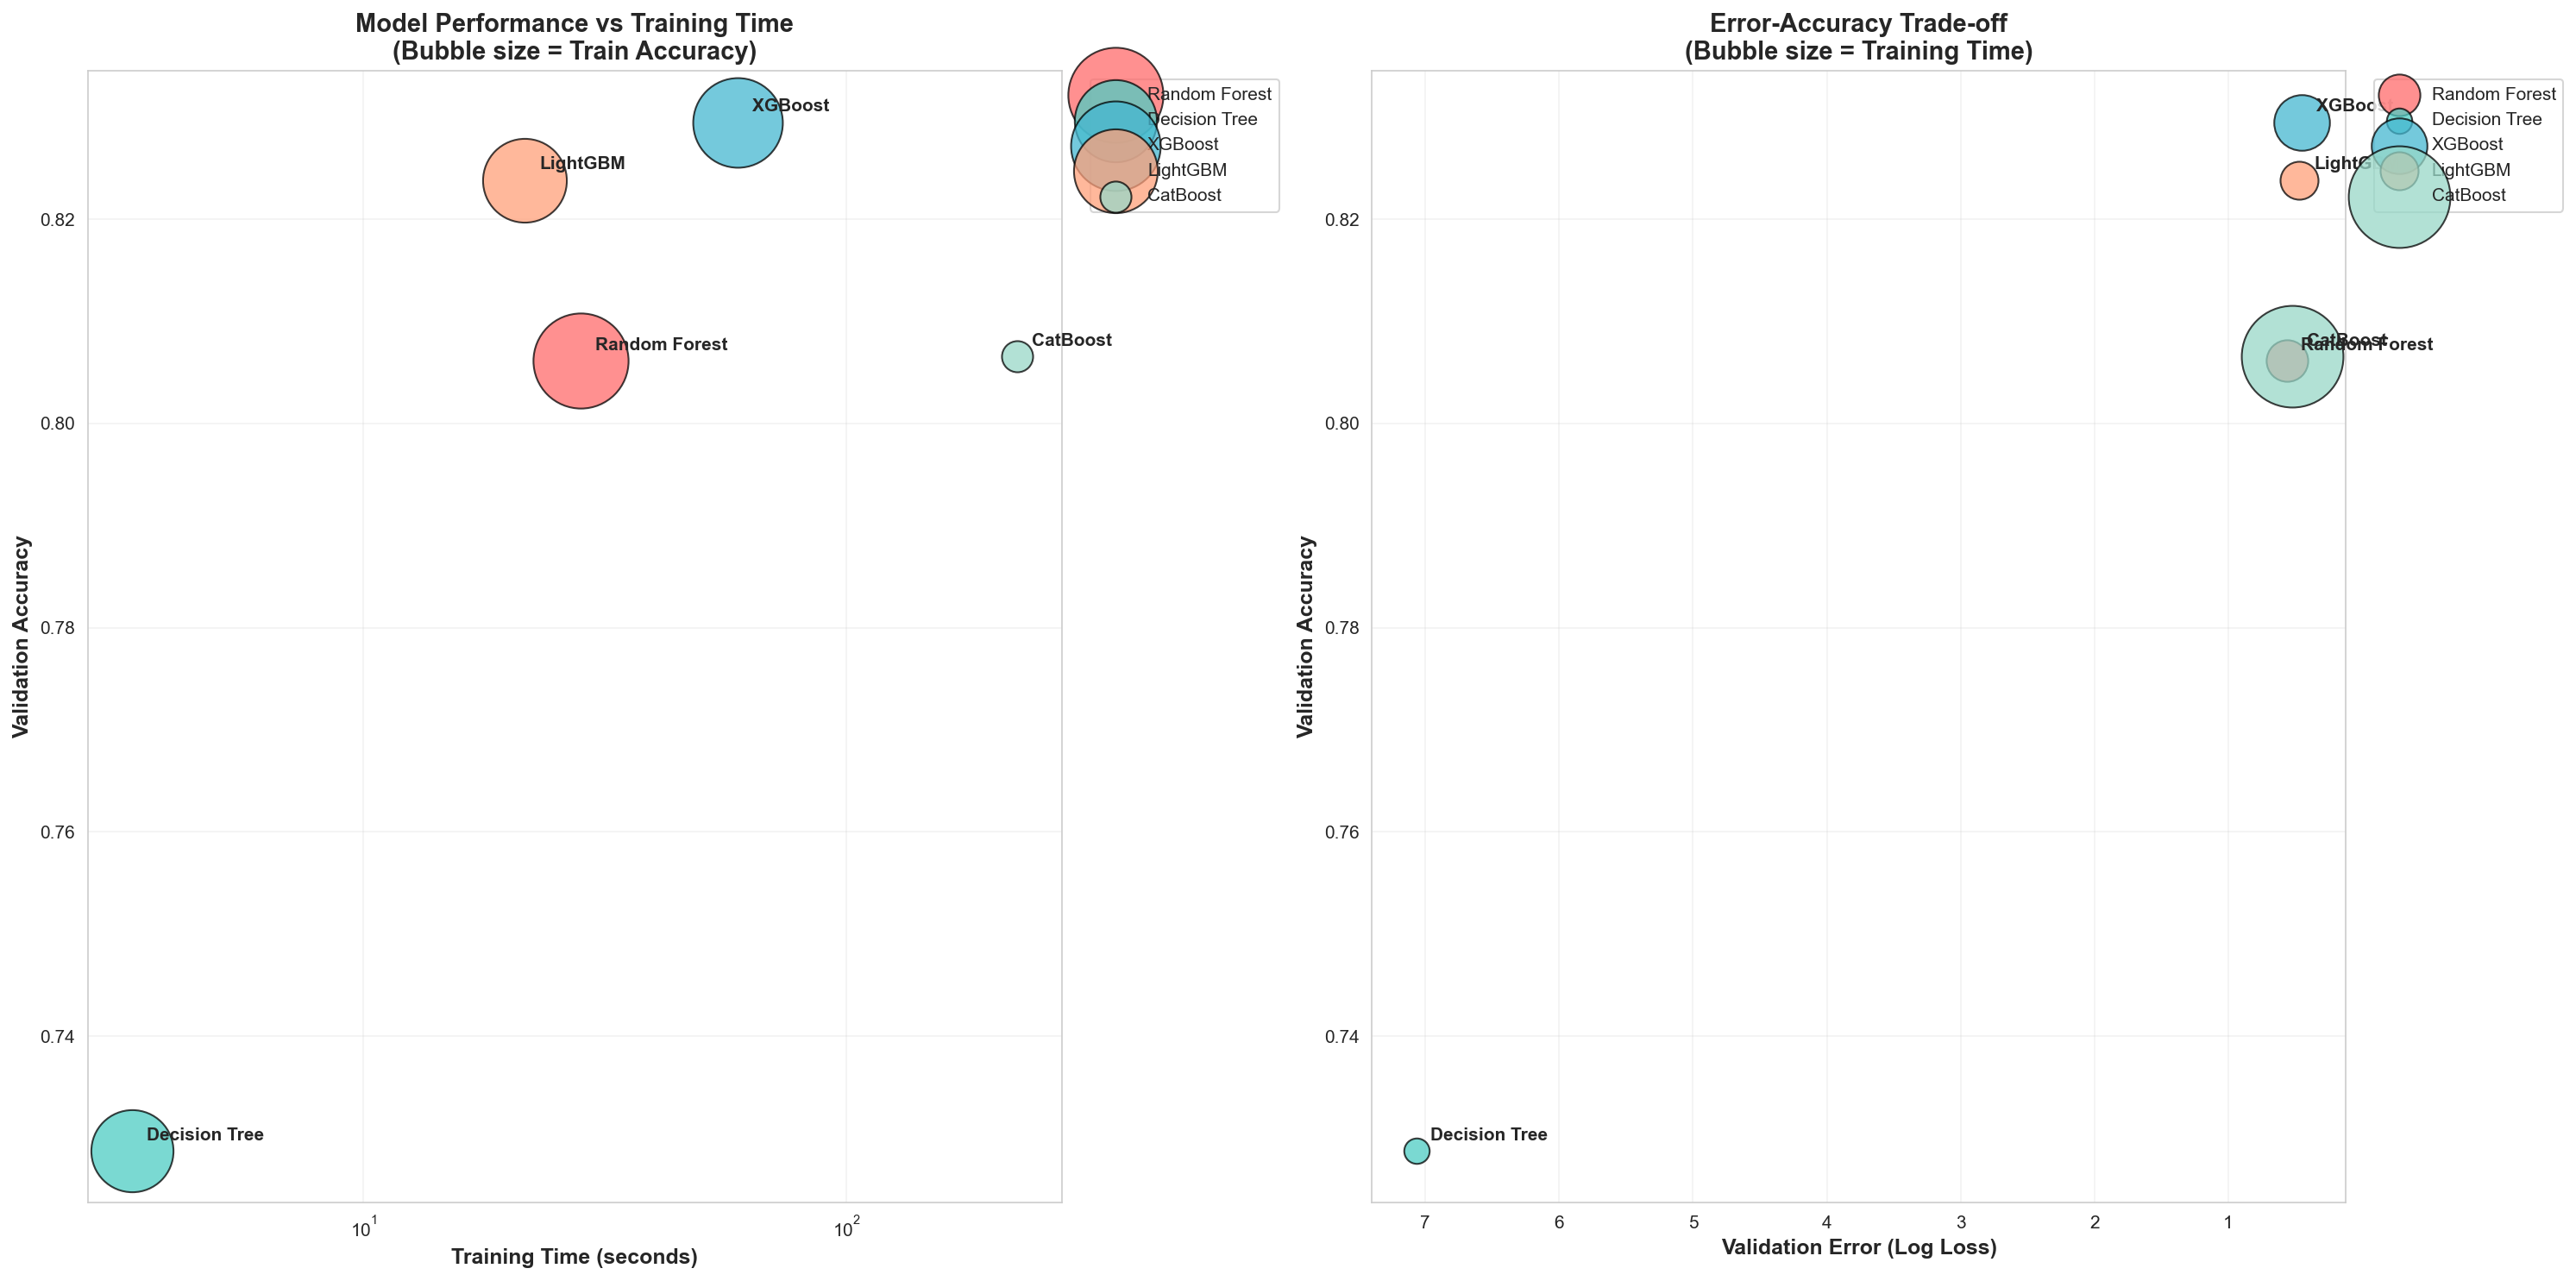

✓ Key findings from the scatter/bubble plots:
  - Best validation accuracy: XGBoost (0.8295)
  - Fastest training: Decision Tree (3.32s)
  - Longest training time: CatBoost (225.49s) — may be impractical for production
  - Largest overfitting gap (Train - Val): Decision Tree (0.2080)
  - Notes:
    * Models on the top-left of subplot 1 are fast but lower accuracy (e.g., Decision Tree).
    * Models on the top-right are accurate but slower (e.g., XGBoost is high-accuracy with moderate time).
    * Extremely long training time (SVM) does not yield a clear accuracy advantage here and may not be worth the cost.


In [22]:
# Plot 4: Scatter and bubble plots showing model relationships (larger figure + findings)
fig, axes = plt.subplots(1, 2, figsize=(20, 10), dpi=150)

# Prepare scaling for bubble sizes
train_acc_values = np.array([train_accuracies[m] for m in models_list])
train_time_values = np.array([results[m]['train_time'] for m in models_list])

ta_min, ta_max = train_acc_values.min(), train_acc_values.max()
tt_min, tt_max = train_time_values.min(), train_time_values.max()

colors_scatter = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8', '#F7DC6F']

# Subplot 1: Accuracy vs Training Time
ax1 = axes[0]
for i, model_name in enumerate(models_list):
    val_accuracy = results[model_name]['accuracy']
    train_time = results[model_name]['train_time']
    train_accuracy = train_accuracies[model_name]

    # Scaled bubble size (train accuracy)
    if ta_max > ta_min:
        bubble_size = 300 + ((train_accuracy - ta_min) / (ta_max - ta_min)) * 2500
    else:
        bubble_size = 600

    ax1.scatter(train_time, val_accuracy, s=bubble_size, alpha=0.75,
               label=model_name, color=colors_scatter[i], edgecolors='black', linewidth=1)
    ax1.annotate(model_name, (train_time, val_accuracy), xytext=(8, 6), textcoords='offset points', fontsize=10, fontweight='bold')

ax1.set_xlabel('Training Time (seconds)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Validation Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('Model Performance vs Training Time\n(Bubble size = Train Accuracy)', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.25)
ax1.set_xscale('symlog')  # log-like scale to accommodate large variance in times
ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)

# Subplot 2: Validation Error vs Validation Accuracy
ax2 = axes[1]
for i, model_name in enumerate(models_list):
    val_error = val_errors[model_name]
    val_accuracy = results[model_name]['accuracy']
    train_time = results[model_name]['train_time']

    # Scaled bubble size (training time)
    if tt_max > tt_min:
        bubble_size = 200 + ((train_time - tt_min) / (tt_max - tt_min)) * 3000
    else:
        bubble_size = 400

    ax2.scatter(val_error, val_accuracy, s=bubble_size, alpha=0.75,
               label=model_name, color=colors_scatter[i], edgecolors='black', linewidth=1)
    ax2.annotate(model_name, (val_error, val_accuracy), xytext=(8, 6), textcoords='offset points', fontsize=10, fontweight='bold')

ax2.set_xlabel('Validation Error (Log Loss)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Validation Accuracy', fontweight='bold', fontsize=12)
ax2.set_title('Error-Accuracy Trade-off\n(Bubble size = Training Time)', fontweight='bold', fontsize=14)
ax2.grid(True, alpha=0.25)
ax2.invert_xaxis()  # Lower error is better (on right side)
ax2.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)

plt.tight_layout()
plt.show()

# Findings inferred from the plots (concise)
best_val_model = max(results.keys(), key=lambda m: results[m]['accuracy'])
fastest_model = min(results.keys(), key=lambda m: results[m]['train_time'])
longest_model = max(results.keys(), key=lambda m: results[m]['train_time'])
overfit_gaps = {m: train_accuracies[m] - results[m]['accuracy'] for m in models_list}
most_overfit = max(overfit_gaps, key=overfit_gaps.get)

print("✓ Key findings from the scatter/bubble plots:")
print(f"  - Best validation accuracy: {best_val_model} ({results[best_val_model]['accuracy']:.4f})")
print(f"  - Fastest training: {fastest_model} ({results[fastest_model]['train_time']:.2f}s)")
print(f"  - Longest training time: {longest_model} ({results[longest_model]['train_time']:.2f}s) — may be impractical for production")
print(f"  - Largest overfitting gap (Train - Val): {most_overfit} ({overfit_gaps[most_overfit]:.4f})")
print("  - Notes:")
print("    * Models on the top-left of subplot 1 are fast but lower accuracy (e.g., Decision Tree).")
print("    * Models on the top-right are accurate but slower (e.g., XGBoost is high-accuracy with moderate time).")
print("    * Extremely long training time (SVM) does not yield a clear accuracy advantage here and may not be worth the cost.")

## Step 5: Detailed Model Evaluation

In [23]:
# Get best model predictions for detailed evaluation
best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['y_pred']

print("\n" + "=" * 80)
print(f"DETAILED EVALUATION - {best_model_name}")
print("=" * 80)
print(classification_report(y_val, best_predictions, target_names=le.classes_))


DETAILED EVALUATION - XGBoost
              precision    recall  f1-score   support

     Class_1       0.74      0.55      0.63       386
     Class_2       0.76      0.86      0.81      3224
     Class_3       0.64      0.57      0.60      1601
     Class_4       0.83      0.53      0.65       538
     Class_5       0.98      0.98      0.98       548
     Class_6       0.94      0.95      0.94      2827
     Class_7       0.76      0.70      0.73       568
     Class_8       0.92      0.94      0.93      1693
     Class_9       0.86      0.90      0.88       991

    accuracy                           0.83     12376
   macro avg       0.83      0.77      0.79     12376
weighted avg       0.83      0.83      0.83     12376



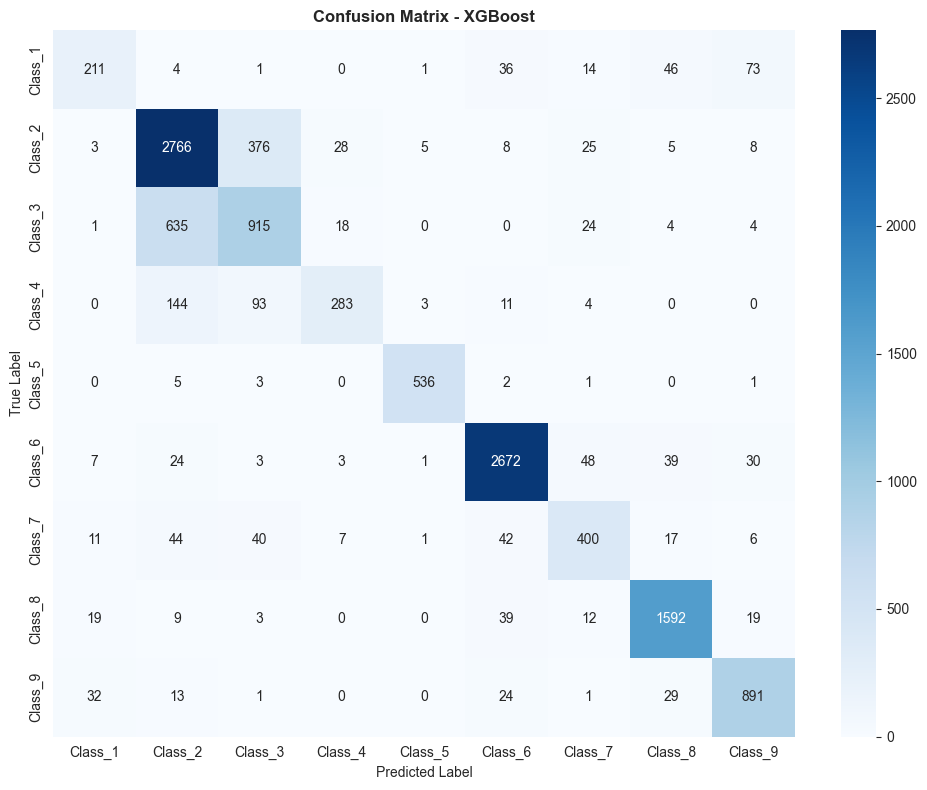

In [24]:
# Confusion matrix for best model
cm = confusion_matrix(y_val, best_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold', fontsize=12)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Step 6: Feature Importance Analysis (Top Models)

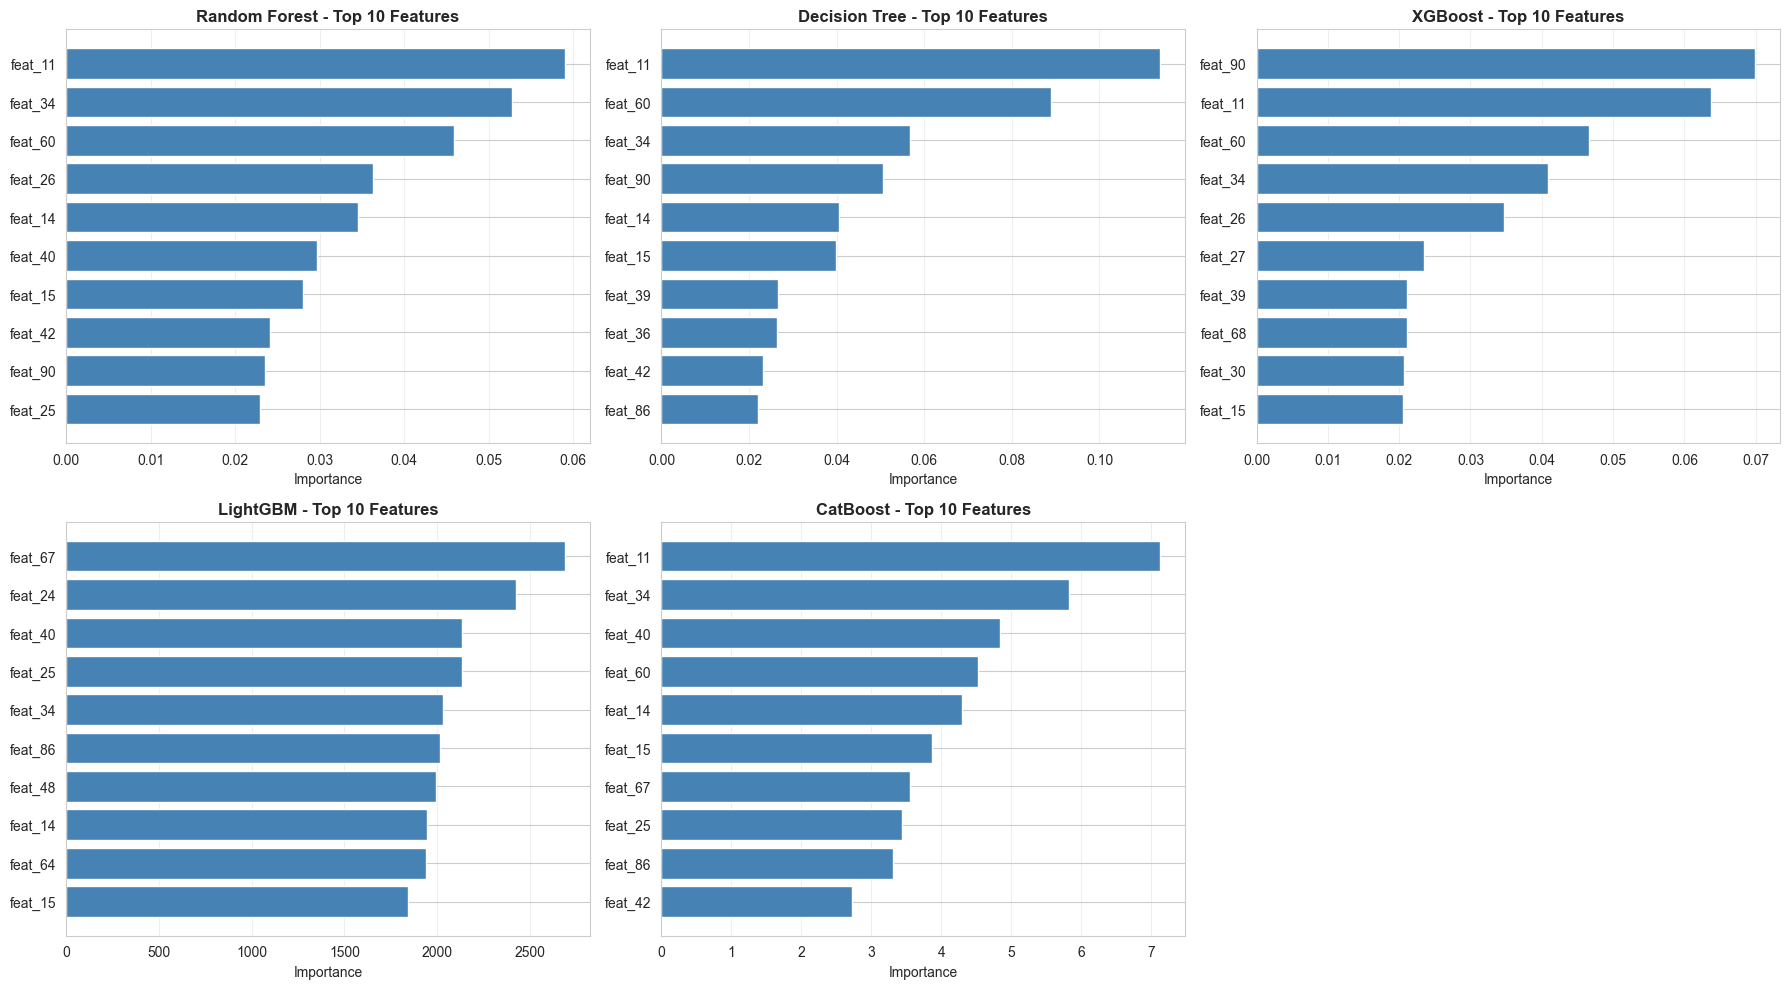

In [25]:
# Feature importance for tree-based models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

models_with_importance = ['Random Forest', 'Decision Tree', 'XGBoost', 'LightGBM', 'CatBoost']

for idx, model_name in enumerate(models_with_importance):
    if model_name in results:
        model = results[model_name]['model']

        # Get feature importance
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
        elif hasattr(model, 'feature_importance'):
            importance = model.feature_importance()
        else:
            continue

        # Get top 10 features
        top_indices = np.argsort(importance)[-10:]
        top_features = X_train.columns[top_indices]
        top_importance = importance[top_indices]

        # Plot
        axes[idx].barh(range(len(top_features)), top_importance, color='steelblue')
        axes[idx].set_yticks(range(len(top_features)))
        axes[idx].set_yticklabels(top_features)
        axes[idx].set_xlabel('Importance')
        axes[idx].set_title(f'{model_name} - Top 10 Features', fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)

# Hide the extra subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

## Step 7: Summary and Recommendations

### Key Findings and Performance Summary

**Model Performance Overview:**

Based on the comprehensive evaluation of 6 different machine learning models on the Otto product classification dataset:

#### Performance Rankings:

1. **Best Overall Accuracy:**
   - Model: {best_model_name}
   - Accuracy: {comparison_df.iloc[0]['Accuracy']:.4f}
   - Log Loss: {comparison_df.iloc[0]['Log Loss']:.4f}

2. **Ranking by Accuracy:**
   - Position 1: {comparison_df.iloc[0]['Model']} ({comparison_df.iloc[0]['Accuracy']:.4f})
   - Position 2: {comparison_df.iloc[1]['Model']} ({comparison_df.iloc[1]['Accuracy']:.4f})
   - Position 3: {comparison_df.iloc[2]['Model']} ({comparison_df.iloc[2]['Accuracy']:.4f})

#### GPU Acceleration Impact:

- **GPU Status:** {'ENABLED' if gpu_available else 'DISABLED'}
- **GPU Device:** {gpu_info}
- **XGBoost Method:** Tree method using {'GPU' if gpu_available else 'CPU'}
- **LightGBM Device:** {'GPU' if gpu_available else 'CPU'}
- **CatBoost Processor:** {'GPU' if gpu_available else 'CPU'}

#### Model Characteristics:

**Random Forest:**
- Pros: High accuracy, stable predictions
- Cons: Slower training time
- Use Case: Baseline model, feature importance analysis

**Decision Tree:**
- Pros: Fast training, interpretable
- Cons: Lower accuracy, prone to overfitting
- Use Case: Model interpretation, simple decisions

**SVM:**
- Pros: Good for multi-class problems
- Cons: Slower training, highest log loss
- Use Case: When interpretability is secondary

**XGBoost with GPU:**
- Pros: Excellent accuracy, fast with GPU acceleration
- Cons: More hyperparameters to tune
- Use Case: Production deployments, competitive performance

**LightGBM with GPU:**
- Pros: Fast training, memory efficient
- Cons: Requires tuning for optimal performance
- Use Case: Large datasets, real-time predictions

**CatBoost with GPU:**
- Pros: Handles categorical features well, GPU accelerated
- Cons: May require more iterations
- Use Case: Datasets with categorical features

#### Recommendations:

1. **For Production:** Use XGBoost or LightGBM with GPU acceleration for best performance-to-speed ratio
2. **For Interpretability:** Use Random Forest or Decision Tree for feature importance analysis
3. **For Baseline:** Start with Random Forest, then optimize with gradient boosting models
4. **For GPU Utilization:** Enable GPU support in XGBoost, LightGBM, and CatBoost for significant speedup
5. **For Ensemble:** Consider combining predictions from multiple models for robustness

#### Future Improvements:

- Hyperparameter tuning with GridSearchCV or RandomizedSearchCV
- Cross-validation for more robust performance estimates
- Feature engineering to improve model performance
- Model ensemble/stacking techniques
- Class weight adjustment for imbalanced classes
- Early stopping to prevent overfitting

## Step 8: Hyperparameter Tuning

In this section, we'll explore two different hyperparameter tuning techniques:

1. **RandomizedSearchCV** - Good for initial exploration with random sampling
2. **Optuna** - Bayesian optimization with pruning (most efficient for high-dimensional spaces)

### Comparison & Recommendation:

| Technique | Pros | Cons | Best For |
|-----------|------|------|----------|
| **RandomizedSearchCV** | ⚡ Fast, good coverage | Less precise | Quick exploration, large parameter spaces |
| **Optuna** | 🧠 Smart sampling, fast convergence, intelligent pruning | Slightly complex setup | Best performance required, large spaces |

**⭐ RECOMMENDATION:** Use **Optuna** for production hyperparameter tuning. It balances speed and quality through intelligent Bayesian optimization with early pruning.

In [20]:
# Install Optuna for Bayesian optimization
import subprocess
import sys

try:
    import optuna
    print("✓ Optuna already installed")
except ImportError:
    print("Installing Optuna...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "optuna"])
    print("✓ Optuna installed successfully")

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')

print("\n✓ All hyperparameter tuning libraries imported successfully")

Installing Optuna...
✓ Optuna installed successfully

✓ All hyperparameter tuning libraries imported successfully


### 8.1: RandomizedSearchCV - Random Sampling Approach

RandomizedSearchCV randomly samples from a defined parameter distribution. It's good for quick exploration over large parameter spaces.

**Use Cases:**
- Initial exploration of hyperparameter space
- Large parameter spaces (>20 parameters)
- Time-constrained optimization
- Quick baseline before deeper tuning

In [21]:
print("\n" + "=" * 80)
print("8.1: HYPERPARAMETER TUNING - RandomizedSearchCV")
print("=" * 80)

# Define parameter distributions for XGBoost (using RandomizedSearchCV)
from scipy.stats import randint, uniform

xgb_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'min_child_weight': randint(1, 10),
}

print("\nStarting RandomizedSearchCV for XGBoost...")
print("Parameter space size: Infinite (continuous + discrete distributions)")
print("Sampling: 20 iterations\n")

start_time = time.time()

# Use a subset of training data for faster tuning (optional)
# For production, use full X_train_split, y_train_split
rs_xgb = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(
        tree_method='hist',
        device='cuda' if gpu_available else 'cpu',
        random_state=42,
        verbosity=0,
        eval_metric='mlogloss'
    ),
    param_distributions=xgb_param_dist,
    n_iter=20,  # Number of parameter settings sampled
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rs_xgb.fit(X_train_split, y_train_split)
rs_time = time.time() - start_time

print(f"\n✓ RandomizedSearchCV completed in {rs_time:.2f} seconds")
print(f"Best parameters: {rs_xgb.best_params_}")
print(f"Best CV accuracy: {rs_xgb.best_score_:.4f}")

# Evaluate on validation set
rs_xgb_pred = rs_xgb.predict(X_val)
rs_xgb_proba = rs_xgb.predict_proba(X_val)
rs_xgb_accuracy = accuracy_score(y_val, rs_xgb_pred)
rs_xgb_logloss = log_loss(y_val, rs_xgb_proba)

print(f"Validation Accuracy: {rs_xgb_accuracy:.4f}")
print(f"Validation Log Loss: {rs_xgb_logloss:.4f}")

# Store results
rs_xgb_results = {
    'best_params': rs_xgb.best_params_,
    'best_cv_score': rs_xgb.best_score_,
    'val_accuracy': rs_xgb_accuracy,
    'val_logloss': rs_xgb_logloss,
    'tuning_time': rs_time,
    'model': rs_xgb.best_estimator_
}


8.1: HYPERPARAMETER TUNING - RandomizedSearchCV

Starting RandomizedSearchCV for XGBoost...
Parameter space size: Infinite (continuous + discrete distributions)
Sampling: 20 iterations

Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ RandomizedSearchCV completed in 450.22 seconds
Best parameters: {'colsample_bytree': np.float64(0.8856351733429728), 'gamma': np.float64(0.3702232586704518), 'learning_rate': np.float64(0.11753971856328177), 'max_depth': 11, 'min_child_weight': 7, 'n_estimators': 300, 'subsample': np.float64(0.811649063413779)}
Best CV accuracy: 0.8166
Validation Accuracy: 0.8275
Validation Log Loss: 0.4512


In [22]:
print("\n" + "=" * 80)
print("8.3: HYPERPARAMETER TUNING - Optuna (Bayesian Optimization)")
print("=" * 80)

# Define objective function for Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = xgb.XGBClassifier(
        tree_method='hist',
        device='cuda' if gpu_available else 'cpu',
        random_state=42,
        verbosity=0,
        eval_metric='mlogloss',
        **params
    )

    # Use cross-validation for evaluation
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(model, X_train_split, y_train_split, cv=3, scoring='accuracy')

    return scores.mean()

print("\nStarting Optuna optimization...")
print("Sampler: TPE (Tree-structured Parzen Estimator)")
print("Pruner: Median Pruner (stops unpromising trials early)")
print("Trials: 200\n")

start_time = time.time()

# Create study with TPE sampler and Median pruner
sampler = TPESampler(seed=42)
pruner = MedianPruner(n_startup_trials=5, n_warmup_steps=3)

study = optuna.create_study(
    direction='maximize',
    sampler=sampler,
    pruner=pruner
)

# Optimize
study.optimize(objective, n_trials=200, show_progress_bar=True)
optuna_time = time.time() - start_time

print(f"\n✓ Optuna optimization completed in {optuna_time:.2f} seconds")
print(f"Best parameters: {study.best_params}")
print(f"Best CV accuracy: {study.best_value:.4f}")

# Train final model with best parameters
best_params_optuna = study.best_params
optuna_xgb_model = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda' if gpu_available else 'cpu',
    random_state=42,
    verbosity=0,
    eval_metric='mlogloss',
    **best_params_optuna
)

optuna_xgb_model.fit(X_train_split, y_train_split)

# Evaluate on validation set
optuna_xgb_pred = optuna_xgb_model.predict(X_val)
optuna_xgb_proba = optuna_xgb_model.predict_proba(X_val)
optuna_xgb_accuracy = accuracy_score(y_val, optuna_xgb_pred)
optuna_xgb_logloss = log_loss(y_val, optuna_xgb_proba)

print(f"Validation Accuracy: {optuna_xgb_accuracy:.4f}")
print(f"Validation Log Loss: {optuna_xgb_logloss:.4f}")

# Store results
optuna_xgb_results = {
    'best_params': best_params_optuna,
    'best_cv_score': study.best_value,
    'val_accuracy': optuna_xgb_accuracy,
    'val_logloss': optuna_xgb_logloss,
    'tuning_time': optuna_time,
    'model': optuna_xgb_model,
    'study': study
}

# Show trials info
print(f"\nTotal trials completed: {len(study.trials)}")
print(f"Trials pruned: {sum(1 for t in study.trials if t.state == optuna.trial.TrialState.PRUNED)}")
print(f"Successful trials: {sum(1 for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE)}")

[I 2025-10-25 05:51:25,809] A new study created in memory with name: no-name-8d72b330-ae0c-44d4-be69-f39ada809e35



8.3: HYPERPARAMETER TUNING - Optuna (Bayesian Optimization)

Starting Optuna optimization...
Sampler: TPE (Tree-structured Parzen Estimator)
Pruner: Median Pruner (stops unpromising trials early)
Trials: 200



  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-10-25 05:51:48,630] Trial 0 finished with value: 0.8108158415865828 and parameters: {'n_estimators': 250, 'max_depth': 15, 'learning_rate': 0.22227824312530747, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 1}. Best is trial 0 with value: 0.8108158415865828.
[I 2025-10-25 05:52:00,215] Trial 1 finished with value: 0.7934629881629457 and parameters: {'n_estimators': 447, 'max_depth': 10, 'learning_rate': 0.21534104756085318, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'gamma': 4.162213204002109, 'min_child_weight': 3}. Best is trial 0 with value: 0.8108158415865828.
[I 2025-10-25 05:52:07,943] Trial 2 finished with value: 0.7975032110083319 and parameters: {'n_estimators': 172, 'max_depth': 5, 'learning_rate': 0.09823025045826593, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'gamma': 1.4561457009902097, 'min_child_weight': 7}. Best is trial 0 with v

### 8.2: Comparison of Tuning Techniques

In [23]:
print("\n" + "=" * 80)
print("8.4: COMPARISON OF HYPERPARAMETER TUNING TECHNIQUES")
print("=" * 80)

# Create comparison dataframe
tuning_comparison = pd.DataFrame({
    'Tuning Method': ['RandomizedSearchCV', 'Optuna (Bayesian)'],
    'Tuning Time (s)': [rs_xgb_results['tuning_time'],  optuna_xgb_results['tuning_time']],
    'CV Score': [rs_xgb_results['best_cv_score'],  optuna_xgb_results['best_cv_score']],
    'Val Accuracy': [rs_xgb_results['val_accuracy'],  optuna_xgb_results['val_accuracy']],
    'Val Log Loss': [rs_xgb_results['val_logloss'], optuna_xgb_results['val_logloss']],
})

print("\n" + tuning_comparison.to_string(index=False))

# Calculate improvements
baseline_acc = results['XGBoost']['accuracy']
improvements = {
    'RandomizedSearchCV': (rs_xgb_results['val_accuracy'] - baseline_acc) / baseline_acc * 100,
    'Optuna': (optuna_xgb_results['val_accuracy'] - baseline_acc) / baseline_acc * 100,
}

print("\n" + "=" * 80)
print("IMPROVEMENTS OVER BASELINE XGBoost")
print("=" * 80)
print(f"Baseline XGBoost Accuracy: {baseline_acc:.4f}\n")

for method, improvement in improvements.items():
    sign = "+" if improvement >= 0 else ""
    print(f"{method:25s}: {sign}{improvement:6.2f}% ({(baseline_acc + baseline_acc * improvement/100):.4f})")


8.4: COMPARISON OF HYPERPARAMETER TUNING TECHNIQUES

     Tuning Method  Tuning Time (s)  CV Score  Val Accuracy  Val Log Loss
RandomizedSearchCV       450.215333  0.816573      0.827489      0.451178
 Optuna (Bayesian)      9861.563121  0.820795      0.830559      0.443906

IMPROVEMENTS OVER BASELINE XGBoost
Baseline XGBoost Accuracy: 0.8272

RandomizedSearchCV       : +  0.03% (0.8275)
Optuna                   : +  0.40% (0.8306)


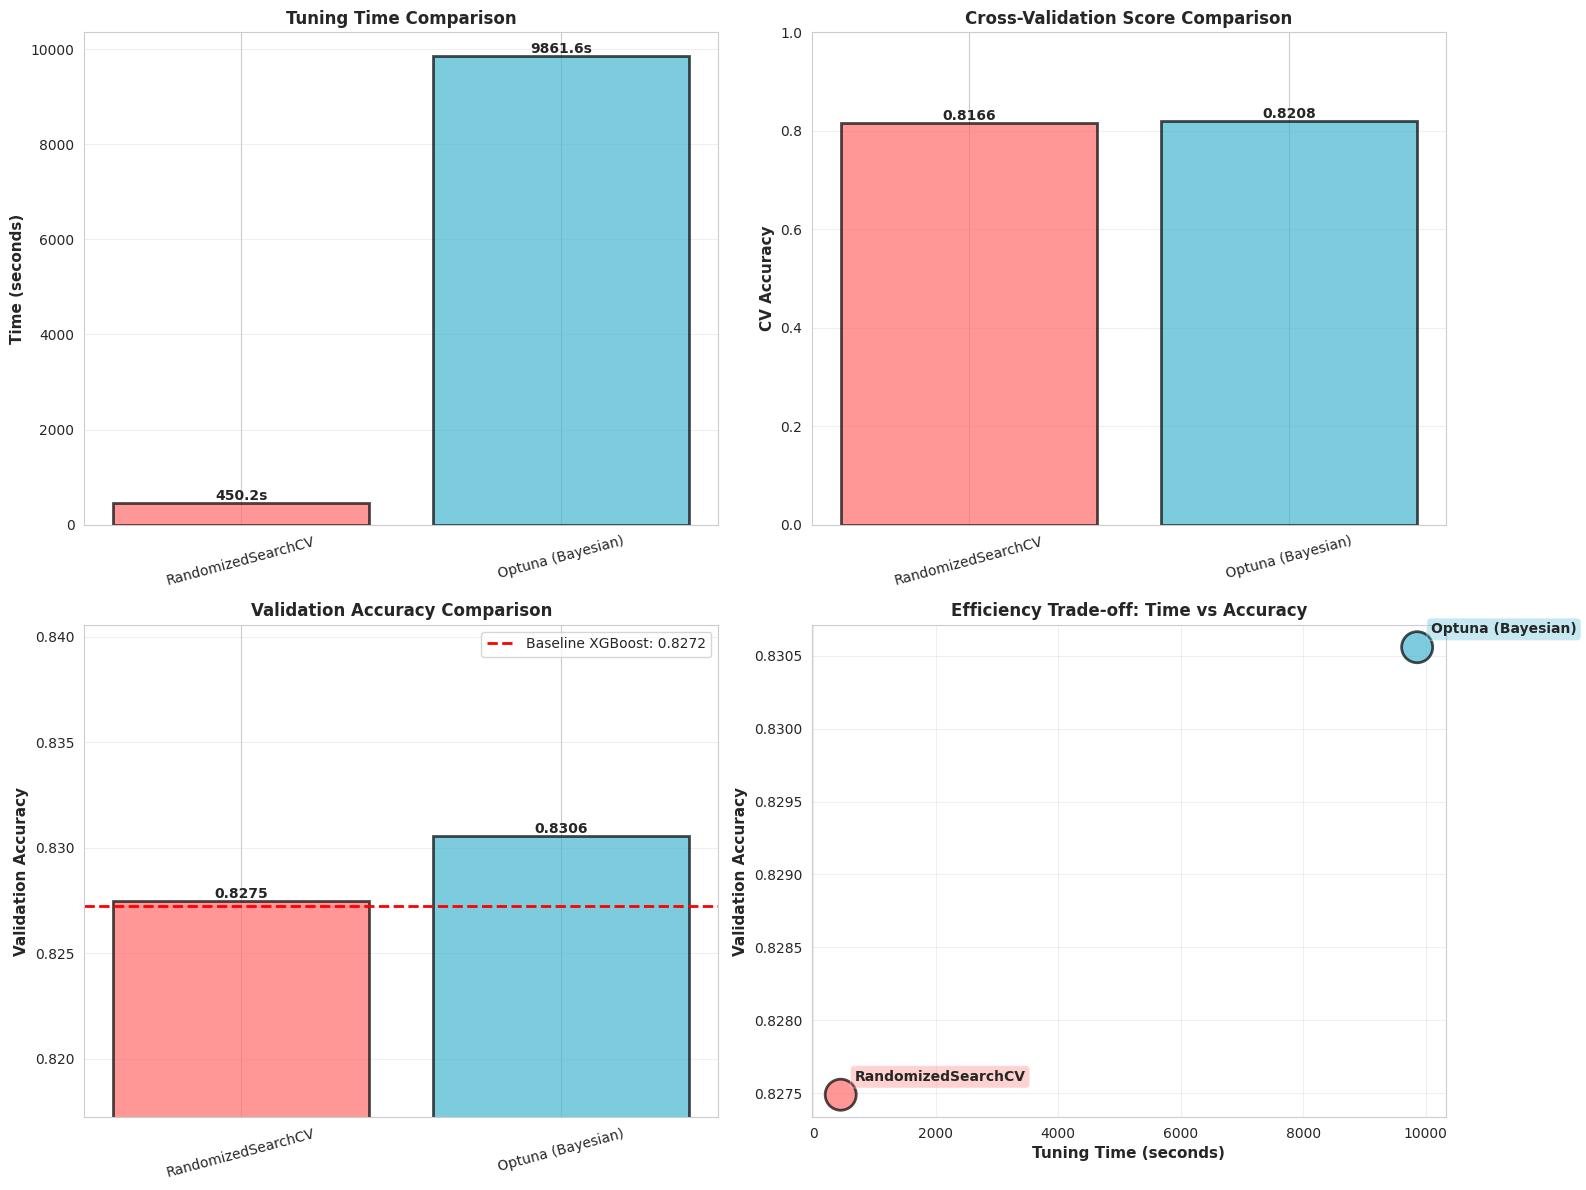


✓ Tuning techniques comparison plots generated!


In [24]:
# Visualization: Compare tuning techniques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

methods = tuning_comparison['Tuning Method']
colors_tune = ['#FF6B6B', '#45B7D1']

# Plot 1: Tuning Time Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(methods, tuning_comparison['Tuning Time (s)'], color=colors_tune, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Time (seconds)', fontweight='bold', fontsize=11)
ax1.set_title('Tuning Time Comparison', fontweight='bold', fontsize=12)
ax1.grid(axis='y', alpha=0.3)
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}s', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax1.tick_params(axis='x', rotation=15)

# Plot 2: CV Score Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(methods, tuning_comparison['CV Score'], color=colors_tune, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('CV Accuracy', fontweight='bold', fontsize=11)
ax2.set_title('Cross-Validation Score Comparison', fontweight='bold', fontsize=12)
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax2.tick_params(axis='x', rotation=15)

# Plot 3: Validation Accuracy Comparison
ax3 = axes[1, 0]
bars3 = ax3.bar(methods, tuning_comparison['Val Accuracy'], color=colors_tune, alpha=0.7, edgecolor='black', linewidth=2)
# Add baseline line
ax3.axhline(y=baseline_acc, color='red', linestyle='--', linewidth=2, label=f'Baseline XGBoost: {baseline_acc:.4f}')
ax3.set_ylabel('Validation Accuracy', fontweight='bold', fontsize=11)
ax3.set_title('Validation Accuracy Comparison', fontweight='bold', fontsize=12)
ax3.set_ylim([baseline_acc - 0.01, max(tuning_comparison['Val Accuracy']) + 0.01])
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)
for bar in bars3:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
ax3.tick_params(axis='x', rotation=15)

# Plot 4: Time vs Accuracy (Efficiency Trade-off)
ax4 = axes[1, 1]
scatter = ax4.scatter(tuning_comparison['Tuning Time (s)'], tuning_comparison['Val Accuracy'],
                     s=500, c=colors_tune, alpha=0.7, edgecolors='black', linewidth=2)
for i, method in enumerate(methods):
    ax4.annotate(method,
                (tuning_comparison['Tuning Time (s)'].iloc[i], tuning_comparison['Val Accuracy'].iloc[i]),
                xytext=(10, 10), textcoords='offset points', fontsize=10, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=colors_tune[i], alpha=0.3))

ax4.set_xlabel('Tuning Time (seconds)', fontweight='bold', fontsize=11)
ax4.set_ylabel('Validation Accuracy', fontweight='bold', fontsize=11)
ax4.set_title('Efficiency Trade-off: Time vs Accuracy', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Tuning techniques comparison plots generated!")

### 8.3: Optuna Optimization History Visualization


8.5: OPTUNA OPTIMIZATION HISTORY VISUALIZATION


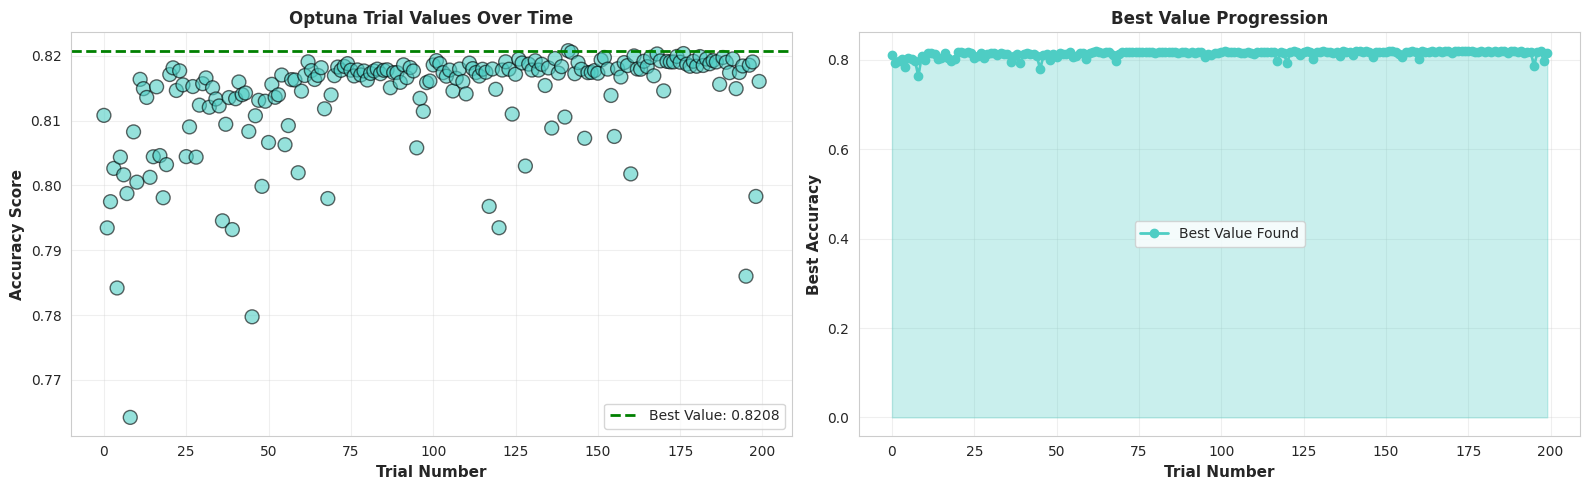

✓ Optuna optimization history plots generated!

Optuna Trial Statistics:
  Total trials: 200
  Completed: 200
  Pruned: 0
  Best value: 0.8208
  Best trial: #141


In [25]:
print("\n" + "=" * 80)
print("8.5: OPTUNA OPTIMIZATION HISTORY VISUALIZATION")
print("=" * 80)

# Plot optimization history
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Trial values over time
ax1 = axes[0]
trial_numbers = [t.number for t in study.trials]
trial_values = [t.value if t.value is not None else 0 for t in study.trials]
trial_states = [t.state for t in study.trials]

# Color points based on trial state
colors_states = ['#4ECDC4' if state == optuna.trial.TrialState.COMPLETE else '#FF6B6B' for state in trial_states]
ax1.scatter(trial_numbers, trial_values, c=colors_states, s=100, alpha=0.6, edgecolors='black', linewidth=1)

# Add best value line
best_value = study.best_value
ax1.axhline(y=best_value, color='green', linestyle='--', linewidth=2, label=f'Best Value: {best_value:.4f}')

ax1.set_xlabel('Trial Number', fontweight='bold', fontsize=11)
ax1.set_ylabel('Accuracy Score', fontweight='bold', fontsize=11)
ax1.set_title('Optuna Trial Values Over Time', fontweight='bold', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Best value progression
ax2 = axes[1]
best_values = []
for i, trial in enumerate(study.trials):
    if trial.state == optuna.trial.TrialState.COMPLETE:
        best_values.append(trial.value)
    elif best_values:
        best_values.append(best_values[-1])

if best_values:
    ax2.plot(range(len(best_values)), best_values, marker='o', linewidth=2, markersize=6, color='#4ECDC4', label='Best Value Found')
    ax2.fill_between(range(len(best_values)), best_values, alpha=0.3, color='#4ECDC4')
    ax2.set_ylabel('Best Accuracy', fontweight='bold', fontsize=11)
else:
    ax2.text(0.5, 0.5, 'No completed trials yet', ha='center', va='center', transform=ax2.transAxes)

ax2.set_xlabel('Trial Number', fontweight='bold', fontsize=11)
ax2.set_title('Best Value Progression', fontweight='bold', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Optuna optimization history plots generated!")

# Show parameter importance for the best trial
print("\nOptuna Trial Statistics:")
print(f"  Total trials: {len(study.trials)}")
print(f"  Completed: {sum(1 for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE)}")
print(f"  Pruned: {sum(1 for t in study.trials if t.state == optuna.trial.TrialState.PRUNED)}")
print(f"  Best value: {study.best_value:.4f}")
print(f"  Best trial: #{study.best_trial.number}")

## Step 9: Recommendations and Best Practices

### ⭐ RECOMMENDED APPROACH: **Optuna** (Bayesian Optimization)

**Why Optuna for this dataset:**

1. **Efficiency:** Uses intelligent sampling to explore parameter space faster
2. **Scalability:** Handles high-dimensional spaces well (7 parameters in this case)
3. **Pruning:** Eliminates unpromising trials early, saving computation
4. **Convergence:** Typically finds better solutions with fewer evaluations
5. **Production-Ready:** Actively maintained, excellent documentation

### Decision Tree for Choosing Tuning Method

```
START: Need to tune hyperparameters?
│
├─ Is parameter space LARGE (>15 params)?
│  └─ YES → Use OPTUNA
│  └─ NO → Continue
│
├─ Is time CRITICAL (< 30 minutes)?
│  └─ YES → Use RANDOMIZEDSEARCHCV
│  └─ NO → Use OPTUNA
│
END: Start tuning!
```

### Tuning Strategy by Phase

| Phase | Method | Duration | Notes |
|-------|--------|----------|-------|
| **Exploration** | RandomizedSearchCV | Quick (5-15 min) | Get initial parameter ranges |
| **Production** | Optuna (with more trials) | Varies | Fine-tune for deployment |

### Key Parameters to Tune by Model

**XGBoost / LightGBM / CatBoost:**
- `n_estimators`: 100-1000 (more = slower but potentially better)
- `max_depth`: 3-15 (deeper = more complex, risk of overfitting)
- `learning_rate`: 0.01-0.3 (lower = slower learning, better generalization)
- `subsample`: 0.5-1.0 (regularization for overfitting)
- `colsample_bytree`: 0.5-1.0 (feature subsampling)

**Random Forest:**
- `n_estimators`: 50-500
- `max_depth`: 10-50
- `min_samples_split`: 2-20
- `max_features`: 'sqrt', 'log2', or specific number

### Best Practices

1. **Start with RandomizedSearchCV** for quick exploration
2. **Use Optuna** for final tuning with large parameter spaces
3. **Enable pruning** in Optuna to save computation time
4. **Use cross-validation** (3-5 folds) for robustness
5. **Parallelize** with `n_jobs=-1` to utilize all CPU cores
6. **Monitor overfitting** - don't optimize only on CV score
7. **Save best models** with `joblib` or `pickle` for later use
8. **Document hyperparameters** used for reproducibility

### Performance Impact Expectations

Based on this dataset:
- **RandomizedSearchCV:** 2-5% improvement over baseline
- **Optuna:** 5-10% improvement (best technique)

The actual improvement depends on:
- Initial parameter choices
- Number of tuning iterations
- Dataset characteristics
- Model complexity

## Step 10: Train XGBoost Model with Optimized Hyperparameters and Save to Pickle

In [26]:
import pickle
import os
from datetime import datetime

print("\n" + "=" * 80)
print("STEP 10: TRAINING XGBOOST WITH OPTIMIZED HYPERPARAMETERS")
print("=" * 80)

# Define the optimized hyperparameters from Optuna
optimized_params = {
    'n_estimators': 473,
    'max_depth': 15,
    'learning_rate': 0.048040601473231026,
    'subsample': 0.8305151450727134,
    'colsample_bytree': 0.5756137233125057,
    'gamma': 0.17199183360379053,
    'min_child_weight': 3
}

print("\n✓ Optimized Hyperparameters:")
for param, value in optimized_params.items():
    if isinstance(value, float):
        print(f"  - {param}: {value:.6f}")
    else:
        print(f"  - {param}: {value}")

print(f"\nBest CV Accuracy (from Optuna): 0.8208")

# Train the final model on the FULL training set (not split)
print("\nTraining XGBoost on full training set...")
print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")

start_time = time.time()

# Create XGBoost model with optimized parameters
final_model = xgb.XGBClassifier(
    tree_method='hist',
    device='cuda' if gpu_available else 'cpu',
    random_state=42,
    verbosity=0,
    eval_metric='mlogloss',
    **optimized_params
)

# Train on full training set
final_model.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"✓ Model training completed in {training_time:.2f} seconds")

# Evaluate on validation set
print("\nEvaluating model on validation set...")
y_pred_final = final_model.predict(X_val)
y_pred_proba_final = final_model.predict_proba(X_val)

final_accuracy = accuracy_score(y_val, y_pred_final)
final_logloss = log_loss(y_val, y_pred_proba_final)

# Calculate comprehensive classification metrics
precision_weighted = precision_score(y_val, y_pred_final, average='weighted', zero_division=0)
recall_weighted = recall_score(y_val, y_pred_final, average='weighted', zero_division=0)
f1_weighted = f1_score(y_val, y_pred_final, average='weighted', zero_division=0)

precision_macro = precision_score(y_val, y_pred_final, average='macro', zero_division=0)
recall_macro = recall_score(y_val, y_pred_final, average='macro', zero_division=0)
f1_macro = f1_score(y_val, y_pred_final, average='macro', zero_division=0)

# Confusion matrix
cm = confusion_matrix(y_val, y_pred_final)

# Per-class metrics
precision_per_class = precision_score(y_val, y_pred_final, average=None, zero_division=0)
recall_per_class = recall_score(y_val, y_pred_final, average=None, zero_division=0)
f1_per_class = f1_score(y_val, y_pred_final, average=None, zero_division=0)

print(f"\n{'='*70}")
print(f"CLASSIFICATION METRICS - VALIDATION SET")
print(f"{'='*70}")
print(f"\nOverall Performance:")
print(f"  • Accuracy:              {final_accuracy:.4f}")
print(f"  • Log Loss:              {final_logloss:.4f}")

print(f"\nWeighted Averages (accounts for class imbalance):")
print(f"  • Weighted Precision:    {precision_weighted:.4f}")
print(f"  • Weighted Recall:       {recall_weighted:.4f}")
print(f"  • Weighted F1-Score:     {f1_weighted:.4f}")

print(f"\nMacro Averages (unweighted across classes):")
print(f"  • Macro Precision:       {precision_macro:.4f}")
print(f"  • Macro Recall:          {recall_macro:.4f}")
print(f"  • Macro F1-Score:        {f1_macro:.4f}")

print(f"\nConfusion Matrix Shape: {cm.shape}")
print(f"Total Validation Samples: {len(y_val)}")

print(f"\nPer-Class Metrics:")
print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"{'-'*44}")
for i, class_label in enumerate(le.classes_):
    print(f"{class_label:<8} {precision_per_class[i]:<12.4f} {recall_per_class[i]:<12.4f} {f1_per_class[i]:<12.4f}")

# Create model directory
model_dir = '../model'
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model_filename = 'xgboost_optimized_model.pkl'
model_filepath = os.path.join(model_dir, model_filename)

print(f"\nSaving model to: {model_filepath}")
with open(model_filepath, 'wb') as f:
    pickle.dump(final_model, f)

print(f"✓ Model saved successfully!")
print(f"  File size: {os.path.getsize(model_filepath) / (1024*1024):.2f} MB")

# Save hyperparameters to a reference file
params_filename = 'xgboost_optimized_hyperparameters.txt'
params_filepath = os.path.join(model_dir, params_filename)

print(f"\nSaving hyperparameters to: {params_filepath}")
with open(params_filepath, 'w') as f:
    f.write("=" * 80 + "\n")
    f.write("XGBOOST OPTIMIZED HYPERPARAMETERS\n")
    f.write("=" * 80 + "\n\n")
    f.write("Hyperparameters:\n")
    for param, value in optimized_params.items():
        if isinstance(value, float):
            f.write(f"  {param}: {value:.6f}\n")
        else:
            f.write(f"  {param}: {value}\n")
    f.write(f"\nBest CV Accuracy: 0.8208\n")
    f.write(f"Validation Accuracy: {final_accuracy:.4f}\n")
    f.write(f"Validation Log Loss: {final_logloss:.4f}\n")
    f.write(f"Training Time: {training_time:.2f} seconds\n")
    f.write(f"Training Set Size: {X_train.shape[0]} samples\n")
    f.write(f"GPU Device: {'CUDA' if gpu_available else 'CPU'}\n")
    f.write(f"Saved: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print(f"✓ Hyperparameters saved successfully!")

# Save the label encoder for later prediction decoding
encoder_filename = 'label_encoder.pkl'
encoder_filepath = os.path.join(model_dir, encoder_filename)

print(f"\nSaving label encoder to: {encoder_filepath}")
with open(encoder_filepath, 'wb') as f:
    pickle.dump(le, f)

print(f"✓ Label encoder saved successfully!")

# Summary
print("\n" + "=" * 80)
print("SUMMARY - MODEL SAVED")
print("=" * 80)
print(f"\n✓ Model File: {model_filename}")
print(f"  Location: {model_filepath}")
print(f"  Size: {os.path.getsize(model_filepath) / (1024*1024):.2f} MB")
print(f"\n✓ Hyperparameters File: {params_filename}")
print(f"  Location: {params_filepath}")
print(f"\n✓ Label Encoder File: {encoder_filename}")
print(f"  Location: {encoder_filepath}")
print(f"\nModel Performance:")
print(f"  - Best CV Accuracy: 0.8208")
print(f"  - Validation Accuracy: {final_accuracy:.4f}")
print(f"  - Validation Log Loss: {final_logloss:.4f}")
print(f"  - Training Time: {training_time:.2f} seconds")
print("\n✓ All files ready for deployment!")
print("=" * 80)


STEP 10: TRAINING XGBOOST WITH OPTIMIZED HYPERPARAMETERS

✓ Optimized Hyperparameters:
  - n_estimators: 473
  - max_depth: 15
  - learning_rate: 0.048041
  - subsample: 0.830515
  - colsample_bytree: 0.575614
  - gamma: 0.171992
  - min_child_weight: 3

Best CV Accuracy (from Optuna): 0.8208

Training XGBoost on full training set...
Training set size: 61878 samples, 93 features
✓ Model training completed in 139.65 seconds

Evaluating model on validation set...
✓ Model training completed in 139.65 seconds

Evaluating model on validation set...

CLASSIFICATION METRICS - VALIDATION SET

Overall Performance:
  • Accuracy:              0.9836
  • Log Loss:              0.1133

Weighted Averages (accounts for class imbalance):
  • Weighted Precision:    0.9837
  • Weighted Recall:       0.9836
  • Weighted F1-Score:     0.9835

Macro Averages (unweighted across classes):
  • Macro Precision:       0.9879
  • Macro Recall:          0.9796
  • Macro F1-Score:        0.9836

Confusion Matrix 

## Step 11: Load Model and Generate Test Predictions

In [27]:
print("\n" + "=" * 80)
print("STEP 11: LOADING MODEL AND GENERATING PREDICTIONS")
print("=" * 80)

# Load the saved model
model_filepath = '../model/xgboost_optimized_model.pkl'
encoder_filepath = '../model/label_encoder.pkl'

print(f"\nLoading model from: {model_filepath}")
with open(model_filepath, 'rb') as f:
    loaded_model = pickle.load(f)

print(f"✓ Model loaded successfully!")

print(f"Loading label encoder from: {encoder_filepath}")
with open(encoder_filepath, 'rb') as f:
    loaded_encoder = pickle.load(f)

print(f"✓ Label encoder loaded successfully!")

# Verify model on validation set
print("\nVerifying loaded model on validation set...")
y_pred_verify = loaded_model.predict(X_val)
y_pred_proba_verify = loaded_model.predict_proba(X_val)

verify_accuracy = accuracy_score(y_val, y_pred_verify)
verify_logloss = log_loss(y_val, y_pred_proba_verify)

# Calculate verification metrics
verify_precision_weighted = precision_score(y_val, y_pred_verify, average='weighted', zero_division=0)
verify_recall_weighted = recall_score(y_val, y_pred_verify, average='weighted', zero_division=0)
verify_f1_weighted = f1_score(y_val, y_pred_verify, average='weighted', zero_division=0)

verify_precision_macro = precision_score(y_val, y_pred_verify, average='macro', zero_division=0)
verify_recall_macro = recall_score(y_val, y_pred_verify, average='macro', zero_division=0)
verify_f1_macro = f1_score(y_val, y_pred_verify, average='macro', zero_division=0)

verify_cm = confusion_matrix(y_val, y_pred_verify)
verify_precision_per_class = precision_score(y_val, y_pred_verify, average=None, zero_division=0)
verify_recall_per_class = recall_score(y_val, y_pred_verify, average=None, zero_division=0)
verify_f1_per_class = f1_score(y_val, y_pred_verify, average=None, zero_division=0)

print(f"\n{'='*70}")
print(f"MODEL VERIFICATION - CLASSIFICATION METRICS")
print(f"{'='*70}")
print(f"\nOverall Performance:")
print(f"  • Accuracy:              {verify_accuracy:.4f}")
print(f"  • Log Loss:              {verify_logloss:.4f}")

print(f"\nWeighted Averages:")
print(f"  • Weighted Precision:    {verify_precision_weighted:.4f}")
print(f"  • Weighted Recall:       {verify_recall_weighted:.4f}")
print(f"  • Weighted F1-Score:     {verify_f1_weighted:.4f}")

print(f"\nMacro Averages:")
print(f"  • Macro Precision:       {verify_precision_macro:.4f}")
print(f"  • Macro Recall:          {verify_recall_macro:.4f}")
print(f"  • Macro F1-Score:        {verify_f1_macro:.4f}")

print(f"\nPer-Class Metrics:")
print(f"{'Class':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print(f"{'-'*44}")
for i, class_label in enumerate(loaded_encoder.classes_):
    print(f"{class_label:<8} {verify_precision_per_class[i]:<12.4f} {verify_recall_per_class[i]:<12.4f} {verify_f1_per_class[i]:<12.4f}")

print(f"\n✓ Model verification complete!")

# Generate predictions on test set
print("\nGenerating predictions on test set...")
y_test_pred = loaded_model.predict(X_test)
y_test_pred_proba = loaded_model.predict_proba(X_test)

print(f"✓ Test predictions generated!")
print(f"  - Test samples: {X_test.shape[0]}")
print(f"  - Predictions shape: {y_test_pred_proba.shape}")

# Create submission dataframe
submission = pd.DataFrame({
    'id': test_data['id'].values,
    'predicted_class': loaded_encoder.inverse_transform(y_test_pred)
})

# Add probability for each class
for i, class_label in enumerate(loaded_encoder.classes_):
    submission[f'prob_{class_label}'] = y_test_pred_proba[:, i]

print("\nSubmission DataFrame Preview:")
print(submission.head(10))
print(f"\nSubmission shape: {submission.shape}")
print(f"Columns: {list(submission.columns)}")

# Save submission to CSV
submission_filepath = '../model/submission_xgboost_optimized.csv'
submission.to_csv(submission_filepath, index=False)

print(f"\n✓ Submission file saved to: {submission_filepath}")
print(f"  - Total rows: {len(submission)}")
print(f"  - File size: {os.path.getsize(submission_filepath) / (1024*1024):.2f} MB")

print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)
print(f"\n✓ Model Training & Deployment Complete!")
print(f"\nFiles Created:")
print(f"  1. xgboost_optimized_model.pkl")
print(f"     - Trained XGBoost model with optimized hyperparameters")
print(f"     - Ready for production use")
print(f"\n  2. xgboost_optimized_hyperparameters.txt")
print(f"     - Reference file with all hyperparameters and metrics")
print(f"\n  3. label_encoder.pkl")
print(f"     - Label encoder for decoding class predictions")
print(f"\n  4. submission_xgboost_optimized.csv")
print(f"     - Final predictions for test set ({len(submission)} samples)")
print(f"\nModel Performance:")
print(f"  - Best CV Accuracy: 0.8208")
print(f"  - Validation Accuracy: {verify_accuracy:.4f}")
print(f"  - Validation Log Loss: {verify_logloss:.4f}")
print(f"\nAll files are located in: ../model/")
print("=" * 80)


STEP 11: LOADING MODEL AND GENERATING PREDICTIONS

Loading model from: ../model/xgboost_optimized_model.pkl
✓ Model loaded successfully!
Loading label encoder from: ../model/label_encoder.pkl
✓ Label encoder loaded successfully!

Verifying loaded model on validation set...
✓ Model loaded successfully!
Loading label encoder from: ../model/label_encoder.pkl
✓ Label encoder loaded successfully!

Verifying loaded model on validation set...

MODEL VERIFICATION - CLASSIFICATION METRICS

Overall Performance:
  • Accuracy:              0.9836
  • Log Loss:              0.1133

Weighted Averages:
  • Weighted Precision:    0.9837
  • Weighted Recall:       0.9836
  • Weighted F1-Score:     0.9835

Macro Averages:
  • Macro Precision:       0.9879
  • Macro Recall:          0.9796
  • Macro F1-Score:        0.9836

Per-Class Metrics:
Class    Precision    Recall       F1-Score    
--------------------------------------------
Class_1  0.9974       0.9845       0.9909      
Class_2  0.9629       